# Readout type selection

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset
import MEI
import matplotlib as mpl
from datetime import date
from datetime import datetime

# Build the dataloaders

In [307]:
#Use dataloaders with generated RGC data
from lurz2020.datasets.mouse_loaders import static_loaders

paths = ['D://inception_loop/RGC_sim_data/data/static27012021_original_images']

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': 1, 
                  'cuda': True,
                  'normalize': True, 
                  'exclude': "images"}

dataloaders_RGCs = static_loaders(**dataset_config)
dat = FileTreeDataset('D://inception_loop/RGC_sim_data/data/static27012021_original_images', "images", "responses")

### Look at the data

In [308]:
tier = 'train'
dataset_name = '27012021_original_images'

images, responses = [], []
for x, y in dataloaders_RGCs[tier][dataset_name]:
    images.append(x.squeeze().cpu().data.numpy())
    responses.append(y.squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} RGC neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "27012021_original_images" contains the responses of 2304 RGC neurons to 4472 images


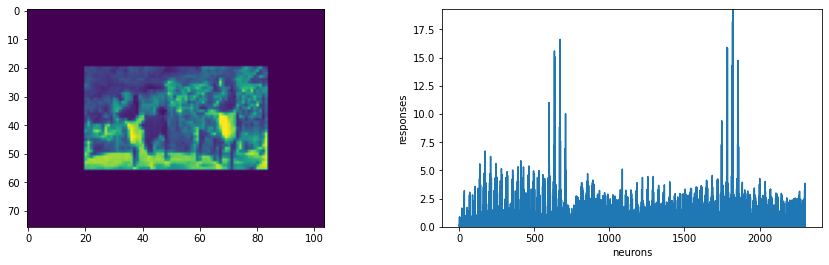

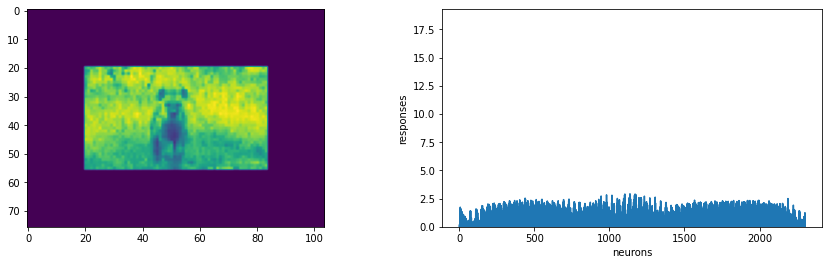

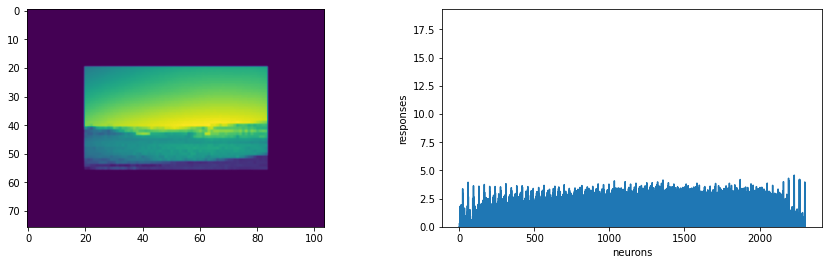

In [5]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

# Build the model, transfer core, train and evaluate performance - 3 readouts types

Build 4 instances of the model for three different readouts:

Fullgaussian readout:

In [12]:
%%time 
%%memit
from lurz2020.models.models import se2d_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

#Generate 4 instances of the same model with different seeds, for MEI generation
n_seeds = 4

models = []
train_correlation_models = []
validation_correlation_models = []
test_correlation_models = []
fraction_oracle = []

#Model config
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}


#Change trainer config to not track and print the training progress
trainer_config = {'track_training': False,
                  'detach_core': True}

#Save information on training
with open("D://inception_loop/RGC_sim_data/models/Train_log_tunned_model_diff_RFs.txt", "a") as log_file:
    date = "Date: " + datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    stim = "Stimuli dataset: " + dataset_name
    model_config = "Model configuration: " + str(model_config_tunned)
    log_file.write(date+'\n'+ stim+'\n'+model_config+'\n')

for i in range(n_seeds): 

    model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=i)
    #Load the weights of the transfer core
    transfer_model = torch.load('D://inception_loop/original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
    model.load_state_dict(transfer_model, strict=False)
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
    #Get performance of model
    train_correlation_models.append(get_correlations(model, dataloaders_RGCs["train"], device='cuda', as_dict=False, per_neuron=False))
    validation_correlation_models.append(get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False))
    test_correlation_models.append(get_correlations(model, dataloaders_RGCs["test"], device='cuda', as_dict=False, per_neuron=False))
    
    oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
    fraction_oracle.append(get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0])

    instance_results = '\n ----------------------------------------- \n \
    Model instance #{0:1d} \n \
    Correlation (train set):      {1:.3f} \n \
    Correlation (validation set): {2:.3f} \n \
    Correlation (test set):       {3:.3f} \n \
    ----------------------------------------- \n \
    Fraction oracle (test set):   {4:.3f} \n'.format(i, train_correlation_models[i], validation_correlation_models[i],
                                                  test_correlation_models[i], fraction_oracle[i])
    
    print(instance_results)
    
    with open("D://inception_loop/RGC_sim_data/models/Train_log_tunned_model_diff_RFs.txt", "a") as log_file:
        log_file.write("\n Model instances training results: \n"+ instance_results)
    
    models.append(model)
    #Save model state for loading later
    torch.save(model_state, 'D://inception_loop/RGC_sim_data/models/tunned_model_diff_RFs_'+str(i)+'.pth')

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[001|00/05] ---> 0.1587192714214325


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[002|00/05] ---> 0.19881710410118103


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[003|00/05] ---> 0.2302725613117218


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[004|00/05] ---> 0.2648564577102661


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[005|00/05] ---> 0.30609503388404846


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[006|00/05] ---> 0.34749484062194824


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[007|00/05] ---> 0.38890618085861206


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[008|00/05] ---> 0.4298163950443268


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[009|00/05] ---> 0.4639325737953186


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[010|00/05] ---> 0.4972185492515564


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[011|00/05] ---> 0.5233685970306396


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[012|00/05] ---> 0.5492935180664062


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[013|00/05] ---> 0.569396436214447


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[014|00/05] ---> 0.590165376663208


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[015|00/05] ---> 0.606425404548645


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[016|00/05] ---> 0.6236133575439453


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[017|00/05] ---> 0.6393992304801941


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[018|00/05] ---> 0.6515399217605591


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[019|00/05] ---> 0.6660134196281433


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[020|00/05] ---> 0.680589497089386


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[021|00/05] ---> 0.6924012303352356


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[022|00/05] ---> 0.7038650512695312


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[023|00/05] ---> 0.7170166373252869


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[024|00/05] ---> 0.7265046834945679


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[025|00/05] ---> 0.7328526377677917


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[026|00/05] ---> 0.7428619861602783


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[027|00/05] ---> 0.752142071723938


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[028|00/05] ---> 0.7635639905929565


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[029|00/05] ---> 0.771385669708252


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[030|00/05] ---> 0.7738001346588135


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[031|00/05] ---> 0.7791115641593933


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[032|00/05] ---> 0.7889382243156433


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[033|00/05] ---> 0.7958590984344482


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[034|00/05] ---> 0.7991306781768799


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[035|00/05] ---> 0.8023709058761597


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[036|00/05] ---> 0.805314302444458


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[037|00/05] ---> 0.8090444207191467


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[038|00/05] ---> 0.8150938749313354


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[039|00/05] ---> 0.8154171705245972


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[040|00/05] ---> 0.8187193274497986


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[041|00/05] ---> 0.8224185109138489


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[042|01/05] -/-> 0.8216696977615356


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[043|01/05] ---> 0.826880156993866


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[044|00/05] ---> 0.8289307355880737


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[045|00/05] ---> 0.8291863203048706


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[046|00/05] ---> 0.831091582775116


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[047|01/05] -/-> 0.8306527137756348


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[048|01/05] ---> 0.8328233361244202


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[049|00/05] ---> 0.8374689221382141


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[050|00/05] ---> 0.8375868201255798


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[051|00/05] ---> 0.8388531804084778


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[052|00/05] ---> 0.8412740230560303


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[053|01/05] -/-> 0.8408184051513672


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[054|01/05] ---> 0.842070460319519


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[055|00/05] ---> 0.8454650640487671


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[056|01/05] -/-> 0.8440107107162476


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[057|02/05] -/-> 0.8436395525932312


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[058|02/05] ---> 0.8473502993583679


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[059|00/05] ---> 0.8476517796516418


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[060|00/05] ---> 0.849284291267395


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[061|01/05] -/-> 0.8487457633018494


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[062|01/05] ---> 0.8500452041625977


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[063|00/05] ---> 0.852530837059021


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[064|00/05] ---> 0.8543952107429504


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[065|00/05] ---> 0.8544981479644775


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[066|01/05] -/-> 0.8518384099006653


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[067|01/05] ---> 0.857428252696991


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[068|01/05] -/-> 0.854919970035553


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[069|02/05] -/-> 0.8563439249992371


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[070|02/05] ---> 0.8579804301261902


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[071|00/05] ---> 0.8585301637649536


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[072|01/05] -/-> 0.8584513664245605


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[073|02/05] -/-> 0.8578740954399109


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[074|02/05] ---> 0.8608970642089844


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[075|00/05] ---> 0.861842691898346


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[076|01/05] -/-> 0.8570398688316345


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[077|02/05] -/-> 0.8571425676345825


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[078|03/05] -/-> 0.8587493896484375


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[079|04/05] -/-> 0.8588473796844482


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[080|05/05] -/-> 0.8615057468414307


Epoch 81:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.72it/s]

Restoring best model after lr decay! 0.861506 ---> 0.861843


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


Epoch    81: reducing learning rate of group 0 to 1.5000e-03.
[081|01/05] -/-> 0.860276460647583


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[082|01/05] ---> 0.8669542074203491


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[083|00/05] ---> 0.869543194770813


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[084|00/05] ---> 0.8696644306182861


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[085|01/05] -/-> 0.8692446947097778


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[086|02/05] -/-> 0.8671972751617432


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[087|03/05] -/-> 0.8669502139091492


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[088|03/05] ---> 0.8701958060264587


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[089|01/05] -/-> 0.8686895370483398


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[090|02/05] -/-> 0.8690611720085144


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[091|02/05] ---> 0.8708689212799072


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[092|01/05] -/-> 0.8690249919891357


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[093|01/05] ---> 0.8718857169151306


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[094|01/05] -/-> 0.8689351677894592


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[095|02/05] -/-> 0.8676784634590149


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[096|03/05] -/-> 0.8702613711357117


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[097|04/05] -/-> 0.8696006536483765


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[098|05/05] -/-> 0.8674653172492981


Epoch 99:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.36it/s]

Restoring best model after lr decay! 0.867465 ---> 0.871886


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


Epoch    99: reducing learning rate of group 0 to 4.5000e-04.
[099|01/05] -/-> 0.8695486187934875


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[100|01/05] ---> 0.8724097609519958


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[101|00/05] ---> 0.8728979825973511


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[102|01/05] -/-> 0.8709148168563843


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[103|02/05] -/-> 0.8707735538482666


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[104|03/05] -/-> 0.8714966177940369


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[105|03/05] ---> 0.8731143474578857


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[106|01/05] -/-> 0.8703715801239014


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[107|02/05] -/-> 0.8703261017799377


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[108|03/05] -/-> 0.8681497573852539


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[109|03/05] ---> 0.8755767941474915


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[110|01/05] -/-> 0.8728983998298645


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[111|02/05] -/-> 0.8729153275489807


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[112|03/05] -/-> 0.8735064268112183


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[113|04/05] -/-> 0.8732220530509949


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[114|05/05] -/-> 0.8716174364089966
Restoring best model after lr decay! 0.871617 ---> 0.875577
Restoring best model! 0.875577 ---> 0.875577
Returning only test sampler with repeats...


d:\inception_loop\original_code\lurz_2020_code\lurz2020\utility\measures.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(repeated_inputs), np.array(repeated_outputs)
d:\inception_loop\original_code\lurz_2020_code\lurz2020\utility\measures.py:239: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  oracle_performance, _, _, _ = np.linalg.lstsq(np.hstack(oracles)[:, np.newaxis], np.hstack(test_correlation))


-----------------------------------------
Model instance #0
Correlation (train set):      0.894
Correlation (validation set): 0.876
Correlation (test set):       0.834
-----------------------------------------
Fraction oracle (test set):   0.882


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[001|00/05] ---> 0.1580345332622528


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[002|00/05] ---> 0.19861944019794464


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[003|00/05] ---> 0.23044627904891968


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[004|00/05] ---> 0.2639283239841461


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[005|00/05] ---> 0.30376332998275757


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[006|00/05] ---> 0.3487289249897003


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[007|00/05] ---> 0.3859824538230896


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[008|00/05] ---> 0.426141619682312


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[009|00/05] ---> 0.4594329595565796


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[010|00/05] ---> 0.49267202615737915


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[011|00/05] ---> 0.5215442180633545


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[012|00/05] ---> 0.5491074323654175


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[013|00/05] ---> 0.572160005569458


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[014|00/05] ---> 0.5945277214050293


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[015|00/05] ---> 0.6128073930740356


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[016|00/05] ---> 0.6317834854125977


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[017|00/05] ---> 0.6489531993865967


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[018|00/05] ---> 0.6632962822914124


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[019|00/05] ---> 0.6779647469520569


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[020|00/05] ---> 0.6921870112419128


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[021|00/05] ---> 0.7032535076141357


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[022|00/05] ---> 0.7111290693283081


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[023|00/05] ---> 0.7225935459136963


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[024|00/05] ---> 0.7316453456878662


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[025|00/05] ---> 0.7352998852729797


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[026|00/05] ---> 0.745086669921875


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[027|00/05] ---> 0.7525826692581177


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[028|00/05] ---> 0.7625500559806824


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[029|00/05] ---> 0.7694615125656128


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[030|00/05] ---> 0.7714134454727173


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[031|00/05] ---> 0.7747859954833984


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[032|00/05] ---> 0.7836732864379883


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[033|00/05] ---> 0.7902028560638428


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[034|00/05] ---> 0.7946433424949646


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[035|00/05] ---> 0.796635091304779


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[036|00/05] ---> 0.7995885014533997


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[037|00/05] ---> 0.8036898374557495


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[038|00/05] ---> 0.8101187944412231


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[039|00/05] ---> 0.8115317821502686


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[040|00/05] ---> 0.8150328397750854


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[041|00/05] ---> 0.8190879821777344


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[042|01/05] -/-> 0.8190643787384033


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[043|01/05] ---> 0.8251676559448242


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[044|00/05] ---> 0.8256781101226807


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[045|00/05] ---> 0.8261960744857788


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[046|00/05] ---> 0.8292267322540283


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[047|01/05] -/-> 0.8281978964805603


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[048|01/05] ---> 0.8310856819152832


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[049|00/05] ---> 0.8358081579208374


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[050|01/05] -/-> 0.8351814150810242


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[051|01/05] ---> 0.8360433578491211


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[052|00/05] ---> 0.8378962278366089


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[053|01/05] -/-> 0.8377162218093872


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[054|01/05] ---> 0.838144838809967


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[055|00/05] ---> 0.8413101434707642


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[056|01/05] -/-> 0.8400571346282959


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[057|02/05] -/-> 0.8398607969284058


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[058|02/05] ---> 0.8432126045227051


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[059|00/05] ---> 0.8433082103729248


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[060|00/05] ---> 0.8449887037277222


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[061|01/05] -/-> 0.8441798686981201


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[062|01/05] ---> 0.8456770777702332


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[063|00/05] ---> 0.8475640416145325


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[064|00/05] ---> 0.8494112491607666


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[065|00/05] ---> 0.8501414060592651


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[066|01/05] -/-> 0.8465275168418884


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[067|01/05] ---> 0.8522076606750488


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[068|01/05] -/-> 0.8498890399932861


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[069|02/05] -/-> 0.8512940406799316


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[070|02/05] ---> 0.8526421785354614


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[071|00/05] ---> 0.8532798290252686


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[072|00/05] ---> 0.853699266910553


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[073|00/05] ---> 0.8540213108062744


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[074|00/05] ---> 0.8570685982704163


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[075|00/05] ---> 0.8581251502037048


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[076|01/05] -/-> 0.8538815975189209


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[077|02/05] -/-> 0.8536622524261475


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[078|03/05] -/-> 0.85521000623703


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[079|04/05] -/-> 0.854964017868042


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[080|05/05] -/-> 0.85743647813797


Epoch 81:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 11.19it/s]

Restoring best model after lr decay! 0.857436 ---> 0.858125


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


Epoch    81: reducing learning rate of group 0 to 1.5000e-03.
[081|01/05] -/-> 0.8571727275848389


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[082|01/05] ---> 0.86314857006073


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[083|00/05] ---> 0.865661084651947


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[084|00/05] ---> 0.8658282160758972


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[085|01/05] -/-> 0.8654640913009644


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[086|02/05] -/-> 0.8637837171554565


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[087|03/05] -/-> 0.8633646368980408


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[088|03/05] ---> 0.8665716052055359


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[089|01/05] -/-> 0.8650112152099609


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[090|02/05] -/-> 0.8653700351715088


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[091|02/05] ---> 0.8672784566879272


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[092|01/05] -/-> 0.8656192421913147


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[093|01/05] ---> 0.8684159517288208


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[094|01/05] -/-> 0.8656184077262878


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[095|02/05] -/-> 0.8646373748779297


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[096|03/05] -/-> 0.8669570088386536


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[097|04/05] -/-> 0.8663666248321533


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[098|05/05] -/-> 0.864375114440918


Epoch 99:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.36it/s]

Restoring best model after lr decay! 0.864375 ---> 0.868416


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


Epoch    99: reducing learning rate of group 0 to 4.5000e-04.
[099|01/05] -/-> 0.8659887313842773


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[100|01/05] ---> 0.8688991069793701


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[101|00/05] ---> 0.8694338798522949


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[102|01/05] -/-> 0.8674367070198059


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[103|02/05] -/-> 0.867447018623352


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[104|03/05] -/-> 0.8680870532989502


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[105|03/05] ---> 0.8697878122329712


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[106|01/05] -/-> 0.866986870765686


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[107|02/05] -/-> 0.8671313524246216


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[108|03/05] -/-> 0.8649182915687561


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[109|03/05] ---> 0.8722843527793884


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[110|01/05] -/-> 0.8696222901344299


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[111|02/05] -/-> 0.8696469068527222


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[112|03/05] -/-> 0.8703200221061707


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[113|04/05] -/-> 0.8700406551361084


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[114|05/05] -/-> 0.8684019446372986
Restoring best model after lr decay! 0.868402 ---> 0.872284
Restoring best model! 0.872284 ---> 0.872284
Returning only test sampler with repeats...
-----------------------------------------
Model instance #1
Correlation (train set):      0.892
Correlation (validation set): 0.872
Correlation (test set):       0.832
-----------------------------------------
Fraction oracle (test set):   0.880


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[001|00/05] ---> 0.1582811027765274


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[002|00/05] ---> 0.19833795726299286


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[003|00/05] ---> 0.23104460537433624


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[004|00/05] ---> 0.2673657238483429


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[005|00/05] ---> 0.307787150144577


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[006|00/05] ---> 0.3482816517353058


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[007|00/05] ---> 0.3881013095378876


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[008|00/05] ---> 0.4291759729385376


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[009|00/05] ---> 0.4615785777568817


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[010|00/05] ---> 0.49290403723716736


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[011|00/05] ---> 0.5215343832969666


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[012|00/05] ---> 0.5491197109222412


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[013|00/05] ---> 0.5708398222923279


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[014|00/05] ---> 0.5941826701164246


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[015|00/05] ---> 0.6116639375686646


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[016|00/05] ---> 0.6306412220001221


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[017|00/05] ---> 0.6454781293869019


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[018|00/05] ---> 0.6592485904693604


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[019|00/05] ---> 0.673868715763092


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[020|00/05] ---> 0.6879899501800537


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[021|00/05] ---> 0.6987179517745972


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[022|00/05] ---> 0.7063544392585754


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[023|00/05] ---> 0.7169041037559509


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[024|00/05] ---> 0.727016270160675


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[025|00/05] ---> 0.7320294380187988


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[026|00/05] ---> 0.7408328056335449


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[027|00/05] ---> 0.7488473653793335


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[028|00/05] ---> 0.7593512535095215


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[029|00/05] ---> 0.7664496302604675


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[030|00/05] ---> 0.7679884433746338


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[031|00/05] ---> 0.7729564309120178


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[032|00/05] ---> 0.7820346355438232


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[033|00/05] ---> 0.7898120880126953


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[034|00/05] ---> 0.7934377193450928


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[035|00/05] ---> 0.7950915098190308


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[036|00/05] ---> 0.7981405258178711


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[037|00/05] ---> 0.8012726306915283


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[038|00/05] ---> 0.8071885704994202


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[039|00/05] ---> 0.8073092699050903


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[040|00/05] ---> 0.8111398220062256


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[041|00/05] ---> 0.8147318959236145


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[042|00/05] ---> 0.8149807453155518


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[043|00/05] ---> 0.8205983638763428


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[044|00/05] ---> 0.8217535018920898


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[045|00/05] ---> 0.8220024704933167


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[046|00/05] ---> 0.8247156143188477


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[047|01/05] -/-> 0.823222815990448


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[048|01/05] ---> 0.8256868720054626


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[049|00/05] ---> 0.8303706645965576


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[050|00/05] ---> 0.8310931921005249


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[051|00/05] ---> 0.8322705030441284


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[052|00/05] ---> 0.8342843055725098


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[053|01/05] -/-> 0.8342466354370117


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[054|01/05] ---> 0.8346800208091736


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[055|00/05] ---> 0.8386658430099487


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[056|01/05] -/-> 0.8371925354003906


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[057|02/05] -/-> 0.8366636633872986


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[058|02/05] ---> 0.839793860912323


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[059|00/05] ---> 0.8406336903572083


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[060|00/05] ---> 0.8423030376434326


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[061|01/05] -/-> 0.8412298560142517


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[062|02/05] -/-> 0.8421419858932495


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[063|02/05] ---> 0.8449618816375732


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[064|00/05] ---> 0.8469633460044861


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[065|01/05] -/-> 0.8469420671463013


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[066|02/05] -/-> 0.8441751003265381


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[067|02/05] ---> 0.848842442035675


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[068|01/05] -/-> 0.8469589352607727


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[069|02/05] -/-> 0.8482069373130798


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[070|02/05] ---> 0.850006639957428


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[071|00/05] ---> 0.8501460552215576


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[072|00/05] ---> 0.8503769636154175


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[073|00/05] ---> 0.8504778742790222


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[074|00/05] ---> 0.8529958724975586


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[075|00/05] ---> 0.8541015982627869


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[076|01/05] -/-> 0.8500205874443054


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[077|02/05] -/-> 0.849750816822052


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[078|03/05] -/-> 0.8511835932731628


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[079|04/05] -/-> 0.8518171906471252


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[080|05/05] -/-> 0.8536344766616821


Epoch 81:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 10.87it/s]

Restoring best model after lr decay! 0.853634 ---> 0.854102


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


Epoch    81: reducing learning rate of group 0 to 1.5000e-03.
[081|01/05] -/-> 0.852392852306366


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[082|01/05] ---> 0.8590519428253174


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[083|00/05] ---> 0.8618226647377014


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[084|00/05] ---> 0.8618693947792053


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[085|01/05] -/-> 0.8616668581962585


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[086|02/05] -/-> 0.8597049713134766


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[087|03/05] -/-> 0.8596042990684509


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[088|03/05] ---> 0.8627623319625854


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[089|01/05] -/-> 0.8612940907478333


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[090|02/05] -/-> 0.8615617752075195


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[091|02/05] ---> 0.8635262250900269


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[092|01/05] -/-> 0.8617470860481262


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[093|01/05] ---> 0.8644470572471619


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[094|01/05] -/-> 0.8616427183151245


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[095|02/05] -/-> 0.8604796528816223


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[096|03/05] -/-> 0.8630707859992981


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[097|04/05] -/-> 0.8622205257415771


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[098|05/05] -/-> 0.8602535724639893


Epoch 99:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 11.20it/s]

Restoring best model after lr decay! 0.860254 ---> 0.864447


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


Epoch    99: reducing learning rate of group 0 to 4.5000e-04.
[099|01/05] -/-> 0.8620498776435852


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[100|01/05] ---> 0.8650627136230469


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[101|00/05] ---> 0.8655380606651306


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[102|01/05] -/-> 0.8635571599006653


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[103|02/05] -/-> 0.8635104894638062


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[104|03/05] -/-> 0.8641427159309387


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[105|03/05] ---> 0.8658187389373779


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[106|01/05] -/-> 0.8630639314651489


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[107|02/05] -/-> 0.8631543517112732


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[108|03/05] -/-> 0.8608952164649963


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[109|03/05] ---> 0.8682959675788879


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[110|01/05] -/-> 0.8655715584754944


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[111|02/05] -/-> 0.8655874133110046


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[112|03/05] -/-> 0.8662018179893494


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[113|04/05] -/-> 0.8659544587135315


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[114|05/05] -/-> 0.8643065690994263
Restoring best model after lr decay! 0.864307 ---> 0.868296
Restoring best model! 0.868296 ---> 0.868296
Returning only test sampler with repeats...
-----------------------------------------
Model instance #2
Correlation (train set):      0.887
Correlation (validation set): 0.868
Correlation (test set):       0.826
-----------------------------------------
Fraction oracle (test set):   0.873


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[001|00/05] ---> 0.1604558527469635


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[002|00/05] ---> 0.20091088116168976


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[003|00/05] ---> 0.23358923196792603


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[004|00/05] ---> 0.26878952980041504


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[005|00/05] ---> 0.30834290385246277


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[006|00/05] ---> 0.3489779829978943


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[007|00/05] ---> 0.38632822036743164


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[008|00/05] ---> 0.4248594045639038


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[009|00/05] ---> 0.4587230682373047


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[010|00/05] ---> 0.4928135275840759


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[011|00/05] ---> 0.5197647213935852


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[012|00/05] ---> 0.5463517308235168


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[013|00/05] ---> 0.5694218873977661


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[014|00/05] ---> 0.5931979417800903


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[015|00/05] ---> 0.6100798845291138


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[016|00/05] ---> 0.6278253197669983


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[017|00/05] ---> 0.6441215872764587


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[018|00/05] ---> 0.6593273878097534


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[019|00/05] ---> 0.6724918484687805


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[020|00/05] ---> 0.6870062351226807


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[021|00/05] ---> 0.6988490223884583


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[022|00/05] ---> 0.7081970572471619


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[023|00/05] ---> 0.7212008237838745


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[024|00/05] ---> 0.7315757870674133


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[025|00/05] ---> 0.7354170680046082


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[026|00/05] ---> 0.7432330250740051


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[027|00/05] ---> 0.7515797019004822


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[028|00/05] ---> 0.7619645595550537


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[029|00/05] ---> 0.7681624293327332


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[030|00/05] ---> 0.7702531814575195


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[031|00/05] ---> 0.7748955488204956


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[032|00/05] ---> 0.7831794023513794


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[033|00/05] ---> 0.7898035049438477


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[034|00/05] ---> 0.7933528423309326


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[035|00/05] ---> 0.7950474619865417


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[036|00/05] ---> 0.798945426940918


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[037|00/05] ---> 0.8030428290367126


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[038|00/05] ---> 0.8095999956130981


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[039|00/05] ---> 0.8103674650192261


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[040|00/05] ---> 0.8142951130867004


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[041|00/05] ---> 0.817445695400238


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[042|01/05] -/-> 0.8170043230056763


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[043|01/05] ---> 0.8231751918792725


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[044|00/05] ---> 0.8245051503181458


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[045|00/05] ---> 0.8252966403961182


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[046|00/05] ---> 0.8280815482139587


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[047|01/05] -/-> 0.8280637264251709


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[048|01/05] ---> 0.8295331001281738


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[049|00/05] ---> 0.8341058492660522


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[050|00/05] ---> 0.8345344066619873


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[051|00/05] ---> 0.8360421061515808


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[052|00/05] ---> 0.838106632232666


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[053|01/05] -/-> 0.8379584550857544


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[054|02/05] -/-> 0.8380884528160095


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[055|02/05] ---> 0.8422867059707642


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[056|01/05] -/-> 0.8411905765533447


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[057|02/05] -/-> 0.8411746025085449


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[058|02/05] ---> 0.8452574610710144


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[059|01/05] -/-> 0.8452406525611877


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[060|01/05] ---> 0.8474002480506897


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[061|01/05] -/-> 0.8458261489868164


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[062|01/05] ---> 0.8475584387779236


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[063|00/05] ---> 0.8504133820533752


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[064|00/05] ---> 0.852695882320404


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[065|01/05] -/-> 0.8526297807693481


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[066|02/05] -/-> 0.8491150736808777


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[067|02/05] ---> 0.8537982106208801


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[068|01/05] -/-> 0.8511120676994324


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[069|02/05] -/-> 0.852651834487915


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[070|02/05] ---> 0.8545255064964294


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[071|00/05] ---> 0.8552008271217346


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[072|00/05] ---> 0.8560673594474792


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[073|01/05] -/-> 0.8556615710258484


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[074|01/05] ---> 0.8590446710586548


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[075|00/05] ---> 0.8605005741119385


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[076|01/05] -/-> 0.8558719158172607


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[077|02/05] -/-> 0.8554415702819824


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[078|03/05] -/-> 0.857093870639801


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[079|04/05] -/-> 0.8566900491714478


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[080|05/05] -/-> 0.8597548604011536


Epoch 81:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.72it/s]

Restoring best model after lr decay! 0.859755 ---> 0.860501


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


Epoch    81: reducing learning rate of group 0 to 1.5000e-03.
[081|01/05] -/-> 0.8587537407875061


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[082|01/05] ---> 0.8652462363243103


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[083|00/05] ---> 0.8679729104042053


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[084|00/05] ---> 0.8680758476257324


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[085|01/05] -/-> 0.8677223920822144


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[086|02/05] -/-> 0.8656773567199707


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[087|03/05] -/-> 0.8654614090919495


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[088|03/05] ---> 0.8685775399208069


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[089|01/05] -/-> 0.8669841289520264


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[090|02/05] -/-> 0.8673803806304932


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[091|02/05] ---> 0.8692244291305542


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[092|01/05] -/-> 0.8674620985984802


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[093|01/05] ---> 0.8701691627502441


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[094|01/05] -/-> 0.867321789264679


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[095|02/05] -/-> 0.8662012815475464


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[096|03/05] -/-> 0.8687434792518616


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[097|04/05] -/-> 0.8679326176643372


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[098|05/05] -/-> 0.866032600402832


Epoch 99:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 11.20it/s]

Restoring best model after lr decay! 0.866033 ---> 0.870169


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


Epoch    99: reducing learning rate of group 0 to 4.5000e-04.
[099|01/05] -/-> 0.8676848411560059


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[100|01/05] ---> 0.870681881904602


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[101|00/05] ---> 0.8711476922035217


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[102|01/05] -/-> 0.8691521883010864


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[103|02/05] -/-> 0.8690923452377319


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[104|03/05] -/-> 0.8698151111602783


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[105|03/05] ---> 0.8713889718055725


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[106|01/05] -/-> 0.8686563968658447


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[107|02/05] -/-> 0.8687739968299866


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[108|03/05] -/-> 0.8665322065353394


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[109|03/05] ---> 0.8739392757415771


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[110|01/05] -/-> 0.8712253570556641


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[111|02/05] -/-> 0.8713018298149109


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[112|03/05] -/-> 0.8718816637992859


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[113|04/05] -/-> 0.871638298034668


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[114|05/05] -/-> 0.8699862360954285
Restoring best model after lr decay! 0.869986 ---> 0.873939
Restoring best model! 0.873939 ---> 0.873939
Returning only test sampler with repeats...
-----------------------------------------
Model instance #3
Correlation (train set):      0.893
Correlation (validation set): 0.874
Correlation (test set):       0.832
-----------------------------------------
Fraction oracle (test set):   0.879
peak memory: 2440.27 MiB, increment: 297.74 MiB
Wall time: 1h 18min 43s


In [13]:
#Print results of after training step
results = '\n Results for fullgaussian tunned model: \n \
    ----------------------------------------- \n \
    {0:1d} instances of the model trained \n \
    Mean correlation (train set):      {1:.3f} \n \
    Mean correlation (validation set): {2:.3f} \n \
    Mean correlation (test set):       {3:.3f} \n \
    ----------------------------------------- \n \
    Mean fraction oracle (test set):   {4:.3f} \n'.format(len(train_correlation_models), np.mean(train_correlation_models),
    np.mean(validation_correlation_models), np.mean(test_correlation_models), np.mean(fraction_oracle))

print(results)

#Save in train log file
with open("D://inception_loop/RGC_sim_data/models/Train_log_tunned_model_fullgaussian.txt", "a") as log_file:
    log_file.write(results)

Results for fullgaussian tunned model:
-----------------------------------------
4 instances of the model trained 
Mean correlation (train set):      0.891
Mean correlation (validation set): 0.873
Mean correlation (test set):       0.831
-----------------------------------------
Mean fraction oracle (test set):   0.879


Pointpooled readout:

In [15]:
%%time 
%%memit
from lurz2020.models.models import se2d_pointpooled
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

#Generate 4 instances of se2d_pointpooled model with MultiplePointPooled2d readout
n_seeds = 4

models_pointpooled = []
train_correlation_models = []
validation_correlation_models = []
test_correlation_models = []
fraction_oracle = []

#Model config
model_config_tunned = {'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'gamma_readout': 2.2986,
                'init_range': 0.2,
                'pool_kern': 3,
                'pool_steps': 2}


#Change trainer config to not track and print the training progress
trainer_config = {'track_training': False,
                  'detach_core': True}

#Save information on training
with open("D://inception_loop/RGC_sim_data/models/Train_log_tunned_model_pointpooled.txt", "a") as log_file:
    date = "Date: " + datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    stim = "Stimuli dataset: " + dataset_name
    model_config = "Model configuration: " + str(model_config_tunned)
    log_file.write(date+'\n'+ stim+'\n'+model_config+'\n')

for i in range(n_seeds): 

    model = se2d_pointpooled(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=i)
    #Load the weights of the transfer core
    transfer_model = torch.load('D://inception_loop/original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
    model.load_state_dict(transfer_model, strict=False)
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
    #Get performance of model
    train_correlation_models.append(get_correlations(model, dataloaders_RGCs["train"], device='cuda', as_dict=False, per_neuron=False))
    validation_correlation_models.append(get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False))
    test_correlation_models.append(get_correlations(model, dataloaders_RGCs["test"], device='cuda', as_dict=False, per_neuron=False))
    
    oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
    fraction_oracle.append(get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0])

    instance_results = '\n ----------------------------------------- \n \
    Model instance #{0:1d} \n \
    Correlation (train set):      {1:.3f} \n \
    Correlation (validation set): {1:.3f} \n \
    Correlation (test set):       {1:.3f} \n \
    ----------------------------------------- \n \
    Fraction oracle (test set):   {1:.3f} \n'.format(i, train_correlation_models[i], validation_correlation_models[i],
                                                  test_correlation_models[i], fraction_oracle[i])
    
    print(instance_results)
    
    with open("D://inception_loop/RGC_sim_data/models/Train_log_tunned_model_pointpooled.txt", "a") as log_file:
        log_file.write("\n Model instances training results: \n"+ instance_results)

    models_pointpooled.append(model)
    #Save model state for loading later
    torch.save(model_state, 'D://inception_loop/RGC_sim_data/models/tunned_model_pointpooled_'+str(i)+'.pth')

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[001|00/05] ---> 0.32609817385673523


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[002|00/05] ---> 0.410903662443161


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[003|00/05] ---> 0.4692188799381256


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.05it/s]


[004|00/05] ---> 0.5156448483467102


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.90it/s]


[005|00/05] ---> 0.5537372827529907


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[006|00/05] ---> 0.5826261043548584


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[007|00/05] ---> 0.6066113114356995


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[008|00/05] ---> 0.6274659633636475


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[009|00/05] ---> 0.6410523653030396


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[010|00/05] ---> 0.6556611657142639


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.17it/s]


[011|00/05] ---> 0.6666299104690552


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[012|00/05] ---> 0.6756148934364319


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[013|00/05] ---> 0.6842444539070129


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[014|00/05] ---> 0.6931454539299011


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[015|00/05] ---> 0.6966561079025269


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[016|00/05] ---> 0.7035519480705261


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[017|00/05] ---> 0.7078477144241333


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[018|00/05] ---> 0.7124415636062622


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[019|00/05] ---> 0.7152547836303711


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.90it/s]


[020|00/05] ---> 0.722141444683075


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[021|00/05] ---> 0.7239670157432556


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[022|00/05] ---> 0.7252631783485413


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[023|00/05] ---> 0.7301962971687317


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[024|00/05] ---> 0.7320346832275391


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[025|00/05] ---> 0.7322944402694702


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.96it/s]


[026|00/05] ---> 0.7357001900672913


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[027|00/05] ---> 0.7376062273979187


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[028|00/05] ---> 0.7418915629386902


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[029|00/05] ---> 0.7437909245491028


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[030|01/05] -/-> 0.7415967583656311


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[031|02/05] -/-> 0.7422064542770386


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[032|02/05] ---> 0.7464752197265625


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[033|00/05] ---> 0.7505399584770203


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[034|00/05] ---> 0.7505826950073242


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[035|01/05] -/-> 0.7504163384437561


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[036|02/05] -/-> 0.7499213814735413


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[037|02/05] ---> 0.7517256140708923


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[038|00/05] ---> 0.7570323944091797


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[039|01/05] -/-> 0.7554866075515747


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[040|02/05] -/-> 0.7569957375526428


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[041|02/05] ---> 0.7591301798820496


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[042|01/05] -/-> 0.7571720480918884


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[043|01/05] ---> 0.7607809901237488


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[044|00/05] ---> 0.7616627216339111


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[045|01/05] -/-> 0.7609883546829224


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[046|02/05] -/-> 0.7613722681999207


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[047|03/05] -/-> 0.7588794231414795


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[048|03/05] ---> 0.7621530890464783


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[049|00/05] ---> 0.7654410600662231


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[050|01/05] -/-> 0.7622981667518616


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[051|02/05] -/-> 0.7622303366661072


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[052|02/05] ---> 0.7656060457229614


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[053|01/05] -/-> 0.7634385228157043


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[054|01/05] ---> 0.7658965587615967


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[055|00/05] ---> 0.7672246098518372


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[056|01/05] -/-> 0.7661426067352295


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[057|02/05] -/-> 0.7662034034729004


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[058|03/05] -/-> 0.7669288516044617


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[059|03/05] ---> 0.7681937217712402


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[060|01/05] -/-> 0.7680971622467041


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[061|01/05] ---> 0.7682439088821411


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[062|00/05] ---> 0.7687692642211914


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[063|00/05] ---> 0.7706239223480225


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[064|00/05] ---> 0.7723440527915955


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[065|01/05] -/-> 0.771003007888794


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[066|02/05] -/-> 0.7695119380950928


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[067|02/05] ---> 0.7744613885879517


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[068|01/05] -/-> 0.7721923589706421


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[069|02/05] -/-> 0.7725178599357605


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[070|03/05] -/-> 0.7744466662406921


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[071|03/05] ---> 0.7751116156578064


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[072|01/05] -/-> 0.774321436882019


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[073|02/05] -/-> 0.7745778560638428


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[074|02/05] ---> 0.7761093974113464


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[075|00/05] ---> 0.777324378490448


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[076|01/05] -/-> 0.7747620344161987


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[077|02/05] -/-> 0.7740445733070374


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[078|03/05] -/-> 0.7743183970451355


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[079|04/05] -/-> 0.77447509765625


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[080|04/05] ---> 0.7774679660797119


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[081|00/05] ---> 0.7783827185630798


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[082|00/05] ---> 0.7791163921356201


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[083|01/05] -/-> 0.7774346470832825


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[084|01/05] ---> 0.7800606489181519


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[085|01/05] -/-> 0.7783334255218506


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[086|01/05] ---> 0.7802769541740417


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[087|01/05] -/-> 0.7773739695549011


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[088|02/05] -/-> 0.7801933884620667


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[089|02/05] ---> 0.7809717655181885


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[090|00/05] ---> 0.782296895980835


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[091|01/05] -/-> 0.7806359529495239


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[092|02/05] -/-> 0.7803090810775757


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[093|03/05] -/-> 0.7820670008659363


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[094|04/05] -/-> 0.7788105010986328


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[095|05/05] -/-> 0.78075110912323


Epoch 96:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 10.71it/s]

Restoring best model after lr decay! 0.780751 ---> 0.782297


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


Epoch    96: reducing learning rate of group 0 to 1.5000e-03.
[096|01/05] -/-> 0.7798959016799927


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[097|01/05] ---> 0.7841973900794983


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[098|01/05] -/-> 0.782074511051178


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[099|02/05] -/-> 0.7838780283927917


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[100|03/05] -/-> 0.7838284969329834


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[101|03/05] ---> 0.7867452502250671


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[102|01/05] -/-> 0.7836294174194336


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[103|02/05] -/-> 0.7866694927215576


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[104|03/05] -/-> 0.7843712568283081


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[105|03/05] ---> 0.7877048254013062


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[106|01/05] -/-> 0.7855210900306702


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[107|02/05] -/-> 0.7871976494789124


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[108|03/05] -/-> 0.7869896292686462


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[109|04/05] -/-> 0.786750078201294


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[110|05/05] -/-> 0.7855051755905151


Epoch 111:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 10.88it/s]

Restoring best model after lr decay! 0.785505 ---> 0.787705


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


Epoch   111: reducing learning rate of group 0 to 4.5000e-04.
[111|01/05] -/-> 0.785676121711731


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[112|01/05] ---> 0.7880263924598694


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[113|01/05] -/-> 0.7875858545303345


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[114|02/05] -/-> 0.7862498164176941


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[115|03/05] -/-> 0.785597562789917


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[116|04/05] -/-> 0.7865629196166992


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[117|05/05] -/-> 0.7856749892234802
Restoring best model after lr decay! 0.785675 ---> 0.788026
Restoring best model! 0.788026 ---> 0.788026
Returning only test sampler with repeats...
-----------------------------------------
Model instance #0
Correlation (train set):      0.820
Correlation (validation set): 0.788
Correlation (test set):       0.756
-----------------------------------------
Fraction oracle (test set):   0.800


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[001|00/05] ---> 0.32236239314079285


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[002|00/05] ---> 0.4055262804031372


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[003|00/05] ---> 0.46085670590400696


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[004|00/05] ---> 0.5064831972122192


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[005|00/05] ---> 0.5446133017539978


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[006|00/05] ---> 0.5760575532913208


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[007|00/05] ---> 0.5993668437004089


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[008|00/05] ---> 0.6207693815231323


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[009|00/05] ---> 0.6350564956665039


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[010|00/05] ---> 0.650245726108551


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[011|00/05] ---> 0.6633799076080322


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[012|00/05] ---> 0.6719996929168701


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[013|00/05] ---> 0.6812222599983215


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[014|00/05] ---> 0.6901834607124329


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[015|00/05] ---> 0.6937456130981445


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[016|00/05] ---> 0.7010663151741028


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[017|00/05] ---> 0.7060573101043701


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[018|00/05] ---> 0.7098504304885864


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[019|00/05] ---> 0.7128057479858398


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[020|00/05] ---> 0.7203488945960999


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[021|00/05] ---> 0.7223427891731262


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[022|00/05] ---> 0.7232415080070496


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[023|00/05] ---> 0.7277058362960815


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[024|00/05] ---> 0.7297632098197937


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[025|00/05] ---> 0.72983318567276


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[026|00/05] ---> 0.7328755855560303


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[027|00/05] ---> 0.7349293828010559


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[028|00/05] ---> 0.7390295267105103


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[029|00/05] ---> 0.7412332892417908


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[030|01/05] -/-> 0.7396655082702637


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[031|02/05] -/-> 0.7405139803886414


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[032|02/05] ---> 0.7447885870933533


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[033|00/05] ---> 0.7488105893135071


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[034|00/05] ---> 0.7494466304779053


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[035|01/05] -/-> 0.7482240200042725


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[036|02/05] -/-> 0.7473378777503967


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[037|03/05] -/-> 0.7487664818763733


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[038|03/05] ---> 0.7536780834197998


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[039|01/05] -/-> 0.7519461512565613


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[040|02/05] -/-> 0.7536643147468567


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[041|02/05] ---> 0.755990743637085


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[042|01/05] -/-> 0.7540706396102905


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[043|01/05] ---> 0.7574796080589294


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[044|00/05] ---> 0.7575609683990479


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[045|01/05] -/-> 0.7573397159576416


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[046|01/05] ---> 0.7576413750648499


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[047|01/05] -/-> 0.756554901599884


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[048|01/05] ---> 0.7592995166778564


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[049|00/05] ---> 0.7626572847366333


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[050|01/05] -/-> 0.7597623467445374


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[051|02/05] -/-> 0.7595656514167786


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[052|02/05] ---> 0.7632014155387878


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[053|01/05] -/-> 0.7607825994491577


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[054|01/05] ---> 0.7633257508277893


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[055|00/05] ---> 0.7653548121452332


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[056|01/05] -/-> 0.7637532353401184


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[057|02/05] -/-> 0.764175295829773


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[058|03/05] -/-> 0.765164315700531


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[059|03/05] ---> 0.7664058208465576


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[060|01/05] -/-> 0.7658989429473877


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[061|02/05] -/-> 0.7659254670143127


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[062|03/05] -/-> 0.7663379311561584


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[063|03/05] ---> 0.7679756879806519


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[064|00/05] ---> 0.7697235345840454


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[065|01/05] -/-> 0.7685024738311768


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[066|02/05] -/-> 0.7663492560386658


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[067|02/05] ---> 0.7718890309333801


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[068|01/05] -/-> 0.7691261768341064


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[069|02/05] -/-> 0.7697985768318176


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.97it/s]


[070|03/05] -/-> 0.7717912197113037


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.81it/s]


[071|03/05] ---> 0.7721827030181885


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[072|01/05] -/-> 0.7712469696998596


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.05it/s]


[073|02/05] -/-> 0.7717117667198181


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[074|02/05] ---> 0.7736061811447144


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.08it/s]


[075|00/05] ---> 0.7745229601860046


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.91it/s]


[076|01/05] -/-> 0.7722437381744385


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[077|02/05] -/-> 0.7715030908584595


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[078|03/05] -/-> 0.7716010212898254


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[079|04/05] -/-> 0.7716607451438904


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[080|04/05] ---> 0.7754906415939331


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[081|00/05] ---> 0.7765551805496216


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[082|00/05] ---> 0.777256965637207


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[083|01/05] -/-> 0.7756776809692383


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[084|01/05] ---> 0.7776472568511963


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[085|01/05] -/-> 0.7767395973205566


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[086|01/05] ---> 0.7788841724395752


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[087|01/05] -/-> 0.7758316397666931


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[088|01/05] ---> 0.7789008617401123


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[089|00/05] ---> 0.7796371579170227


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[090|00/05] ---> 0.7807894349098206


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[091|01/05] -/-> 0.7795892357826233


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[092|02/05] -/-> 0.7787505984306335


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[093|02/05] ---> 0.781091570854187


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[094|01/05] -/-> 0.7780689597129822


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[095|02/05] -/-> 0.7794930934906006


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[096|03/05] -/-> 0.778901994228363


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[097|04/05] -/-> 0.7780592441558838


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[098|04/05] ---> 0.7815816402435303


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[099|01/05] -/-> 0.7815016508102417


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[100|02/05] -/-> 0.779464066028595


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[101|02/05] ---> 0.7826189398765564


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[102|00/05] ---> 0.7843972444534302


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[103|01/05] -/-> 0.7827829122543335


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[104|02/05] -/-> 0.7808557152748108


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[105|03/05] -/-> 0.7818998694419861


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[106|04/05] -/-> 0.7828495502471924


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[107|05/05] -/-> 0.7841635346412659


Epoch 108:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 10.87it/s]

Restoring best model after lr decay! 0.784164 ---> 0.784397


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


Epoch   108: reducing learning rate of group 0 to 1.5000e-03.
[108|01/05] -/-> 0.7823657989501953


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[109|01/05] ---> 0.7868955135345459


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[110|01/05] -/-> 0.785655677318573


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[111|02/05] -/-> 0.7850212454795837


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[112|03/05] -/-> 0.7865426540374756


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[113|04/05] -/-> 0.7848238348960876


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[114|05/05] -/-> 0.7856009006500244


Epoch 115:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 10.72it/s]

Restoring best model after lr decay! 0.785601 ---> 0.786896


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


Epoch   115: reducing learning rate of group 0 to 4.5000e-04.
[115|01/05] -/-> 0.7854657173156738


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[116|02/05] -/-> 0.7867612242698669


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[117|03/05] -/-> 0.7858139872550964


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[118|04/05] -/-> 0.7841296792030334


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[119|05/05] -/-> 0.7857946753501892
Restoring best model after lr decay! 0.785795 ---> 0.786896
Restoring best model! 0.786896 ---> 0.786896
Returning only test sampler with repeats...
-----------------------------------------
Model instance #1
Correlation (train set):      0.819
Correlation (validation set): 0.787
Correlation (test set):       0.753
-----------------------------------------
Fraction oracle (test set):   0.797


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[001|00/05] ---> 0.32136011123657227


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[002|00/05] ---> 0.40307149291038513


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[003|00/05] ---> 0.4586929678916931


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[004|00/05] ---> 0.5034588575363159


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[005|00/05] ---> 0.5410059094429016


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[006|00/05] ---> 0.5713958740234375


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[007|00/05] ---> 0.594679057598114


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[008|00/05] ---> 0.6169695854187012


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[009|00/05] ---> 0.6309617161750793


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[010|00/05] ---> 0.646930456161499


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[011|00/05] ---> 0.6598332524299622


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[012|00/05] ---> 0.6684844493865967


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[013|00/05] ---> 0.6773152351379395


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[014|00/05] ---> 0.6858196258544922


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[015|00/05] ---> 0.6889994740486145


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[016|00/05] ---> 0.6963731050491333


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[017|00/05] ---> 0.7003188133239746


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[018|00/05] ---> 0.7041832804679871


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[019|00/05] ---> 0.7073610424995422


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[020|00/05] ---> 0.7135565280914307


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[021|00/05] ---> 0.715927243232727


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[022|00/05] ---> 0.7167551517486572


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[023|00/05] ---> 0.7212148308753967


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[024|00/05] ---> 0.723089337348938


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[025|00/05] ---> 0.7240227460861206


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[026|00/05] ---> 0.7262691855430603


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[027|00/05] ---> 0.72775799036026


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[028|00/05] ---> 0.7316691279411316


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[029|00/05] ---> 0.7337298393249512


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[030|01/05] -/-> 0.7316557168960571


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[031|02/05] -/-> 0.7327665686607361


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[032|02/05] ---> 0.7366968989372253


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[033|00/05] ---> 0.7406057715415955


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[034|00/05] ---> 0.7412267327308655


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[035|01/05] -/-> 0.7399110794067383


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[036|02/05] -/-> 0.739413321018219


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[037|03/05] -/-> 0.7405869960784912


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[038|03/05] ---> 0.7458430528640747


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[039|01/05] -/-> 0.7442249059677124


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[040|01/05] ---> 0.7460339069366455


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[041|00/05] ---> 0.7480396628379822


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[042|01/05] -/-> 0.746290922164917


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[043|01/05] ---> 0.7501968741416931


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[044|00/05] ---> 0.7507975101470947


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[045|00/05] ---> 0.7509186863899231


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[046|01/05] -/-> 0.7506421208381653


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[047|02/05] -/-> 0.7494499683380127


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[048|02/05] ---> 0.7516192197799683


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[049|00/05] ---> 0.7551214694976807


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[050|01/05] -/-> 0.7526986002922058


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[051|02/05] -/-> 0.7527863383293152


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[052|02/05] ---> 0.7564427256584167


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[053|01/05] -/-> 0.7541224956512451


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[054|02/05] -/-> 0.756343424320221


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[055|02/05] ---> 0.7586860656738281


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[056|01/05] -/-> 0.7569810748100281


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[057|02/05] -/-> 0.7569441199302673


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[058|03/05] -/-> 0.7582643032073975


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[059|03/05] ---> 0.7594492435455322


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[060|01/05] -/-> 0.7589913010597229


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[061|02/05] -/-> 0.7585968375205994


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[062|03/05] -/-> 0.7594263553619385


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[063|03/05] ---> 0.7614370584487915


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[064|00/05] ---> 0.7631574869155884


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[065|01/05] -/-> 0.7617126107215881


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[066|02/05] -/-> 0.7602907419204712


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[067|02/05] ---> 0.7653207778930664


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[068|01/05] -/-> 0.762822687625885


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[069|02/05] -/-> 0.7630847096443176


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[070|03/05] -/-> 0.7653017044067383


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[071|03/05] ---> 0.7659756541252136


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[072|01/05] -/-> 0.7648403644561768


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[073|02/05] -/-> 0.7654047012329102


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[074|02/05] ---> 0.7674428820610046


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[075|00/05] ---> 0.7679340243339539


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[076|01/05] -/-> 0.7657559514045715


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[077|02/05] -/-> 0.7647979259490967


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[078|03/05] -/-> 0.7650995254516602


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[079|04/05] -/-> 0.7651520371437073


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[080|04/05] ---> 0.7687809467315674


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[081|00/05] ---> 0.7693703174591064


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[082|00/05] ---> 0.7703436613082886


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[083|01/05] -/-> 0.7687408924102783


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[084|01/05] ---> 0.7704240083694458


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[085|01/05] -/-> 0.769061803817749


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[086|01/05] ---> 0.7710667848587036


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[087|01/05] -/-> 0.7681323289871216


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[088|01/05] ---> 0.7718155980110168


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[089|00/05] ---> 0.771909236907959


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[090|00/05] ---> 0.7726370692253113


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[091|01/05] -/-> 0.7715203762054443


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[092|02/05] -/-> 0.770819902420044


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[093|02/05] ---> 0.7728877663612366


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[094|01/05] -/-> 0.7697860598564148


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[095|02/05] -/-> 0.7716824412345886


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[096|03/05] -/-> 0.7713775634765625


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[097|04/05] -/-> 0.7700574994087219


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[098|04/05] ---> 0.7736095786094666


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[099|01/05] -/-> 0.7735879421234131


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[100|02/05] -/-> 0.771698534488678


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[101|02/05] ---> 0.7749892473220825


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[102|00/05] ---> 0.7766394019126892


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[103|01/05] -/-> 0.7751202583312988


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[104|02/05] -/-> 0.7733855843544006


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[105|03/05] -/-> 0.7742487788200378


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[106|04/05] -/-> 0.7750216722488403


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[107|05/05] -/-> 0.7763817310333252


Epoch 108:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 10.87it/s]

Restoring best model after lr decay! 0.776382 ---> 0.776639


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


Epoch   108: reducing learning rate of group 0 to 1.5000e-03.
[108|01/05] -/-> 0.775153398513794


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[109|01/05] ---> 0.7792214155197144


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[110|01/05] -/-> 0.7781821489334106


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[111|02/05] -/-> 0.7775075435638428


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[112|03/05] -/-> 0.7787550687789917


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[113|04/05] -/-> 0.7771776914596558


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[114|05/05] -/-> 0.7779428362846375


Epoch 115:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 10.87it/s]

Restoring best model after lr decay! 0.777943 ---> 0.779221


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


Epoch   115: reducing learning rate of group 0 to 4.5000e-04.
[115|01/05] -/-> 0.7779477834701538


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[116|01/05] ---> 0.7792302966117859


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[117|01/05] -/-> 0.7782933115959167


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[118|02/05] -/-> 0.7765753269195557


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[119|03/05] -/-> 0.7781898975372314


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[120|04/05] -/-> 0.7779069542884827


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[121|04/05] ---> 0.7797880172729492


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[122|01/05] -/-> 0.7792222499847412


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[123|02/05] -/-> 0.7778885960578918


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[124|02/05] ---> 0.780566930770874


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[125|01/05] -/-> 0.7804448008537292


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[126|02/05] -/-> 0.7787322402000427


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[127|03/05] -/-> 0.7778787612915039


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[128|03/05] ---> 0.7810555100440979


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[129|01/05] -/-> 0.7805682420730591


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[130|02/05] -/-> 0.7783954739570618


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[131|03/05] -/-> 0.7765483856201172


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[132|04/05] -/-> 0.7804020643234253


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[133|05/05] -/-> 0.7775500416755676
Restoring best model after lr decay! 0.777550 ---> 0.781056
Restoring best model! 0.781056 ---> 0.781056
Returning only test sampler with repeats...
-----------------------------------------
Model instance #2
Correlation (train set):      0.815
Correlation (validation set): 0.781
Correlation (test set):       0.752
-----------------------------------------
Fraction oracle (test set):   0.795


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[001|00/05] ---> 0.32455408573150635


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[002|00/05] ---> 0.4062151312828064


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[003|00/05] ---> 0.46202802658081055


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[004|00/05] ---> 0.50925213098526


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[005|00/05] ---> 0.5482417345046997


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[006|00/05] ---> 0.5792587399482727


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[007|00/05] ---> 0.6026857495307922


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[008|00/05] ---> 0.6238114833831787


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[009|00/05] ---> 0.6384725570678711


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[010|00/05] ---> 0.6527103185653687


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[011|00/05] ---> 0.664397656917572


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[012|00/05] ---> 0.6724778413772583


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[013|00/05] ---> 0.6818428635597229


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[014|00/05] ---> 0.6907548308372498


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[015|00/05] ---> 0.694564163684845


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[016|00/05] ---> 0.702055037021637


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[017|00/05] ---> 0.7049334645271301


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[018|00/05] ---> 0.7090388536453247


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[019|00/05] ---> 0.7117621302604675


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[020|00/05] ---> 0.7175254821777344


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[021|00/05] ---> 0.7194401621818542


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[022|00/05] ---> 0.7202937602996826


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[023|00/05] ---> 0.7254673838615417


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[024|00/05] ---> 0.7273862361907959


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[025|01/05] -/-> 0.7272183895111084


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[026|01/05] ---> 0.7304901480674744


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[027|00/05] ---> 0.7319071888923645


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[028|00/05] ---> 0.7365935444831848


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[029|00/05] ---> 0.7388586401939392


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[030|01/05] -/-> 0.7367924451828003


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[031|02/05] -/-> 0.7367847561836243


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[032|02/05] ---> 0.7407195568084717


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[033|00/05] ---> 0.7440381646156311


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[034|00/05] ---> 0.744086503982544


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[035|01/05] -/-> 0.7433899641036987


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[036|02/05] -/-> 0.7425541281700134


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[037|02/05] ---> 0.7441799640655518


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[038|00/05] ---> 0.7485696077346802


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[039|01/05] -/-> 0.7471981048583984


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[040|02/05] -/-> 0.7479850053787231


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[041|02/05] ---> 0.7507408857345581


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[042|01/05] -/-> 0.7486380934715271


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[043|01/05] ---> 0.7520532011985779


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[044|00/05] ---> 0.7525765895843506


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[045|00/05] ---> 0.7526907324790955


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[046|01/05] -/-> 0.7521579265594482


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[047|02/05] -/-> 0.7511917352676392


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[048|02/05] ---> 0.7534976601600647


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[049|00/05] ---> 0.7569207549095154


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[050|01/05] -/-> 0.754459023475647


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[051|02/05] -/-> 0.7544441223144531


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[052|02/05] ---> 0.7581081390380859


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[053|01/05] -/-> 0.7554441094398499


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[054|01/05] ---> 0.7585551142692566


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[055|00/05] ---> 0.7602488994598389


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[056|01/05] -/-> 0.7588171362876892


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[057|02/05] -/-> 0.7591569423675537


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[058|03/05] -/-> 0.7600257396697998


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[059|03/05] ---> 0.7614955902099609


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[060|01/05] -/-> 0.7613411545753479


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[061|02/05] -/-> 0.7613743543624878


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[062|02/05] ---> 0.7619659900665283


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[063|00/05] ---> 0.764249324798584


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[064|00/05] ---> 0.7653219699859619


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[065|01/05] -/-> 0.7640354633331299


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[066|02/05] -/-> 0.7628034949302673


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[067|02/05] ---> 0.7678897380828857


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[068|01/05] -/-> 0.7660840153694153


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[069|02/05] -/-> 0.7659685611724854


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[070|02/05] ---> 0.7683796286582947


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[071|00/05] ---> 0.7691783905029297


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[072|01/05] -/-> 0.7685625553131104


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[073|02/05] -/-> 0.7688688039779663


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[074|02/05] ---> 0.7706871032714844


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[075|00/05] ---> 0.7719078063964844


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[076|01/05] -/-> 0.7694346904754639


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[077|02/05] -/-> 0.7679476737976074


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[078|03/05] -/-> 0.768372654914856


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[079|04/05] -/-> 0.7686594128608704


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[080|04/05] ---> 0.7725310921669006


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[081|00/05] ---> 0.7730695605278015


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[082|00/05] ---> 0.7737079858779907


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[083|01/05] -/-> 0.7721981406211853


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[084|01/05] ---> 0.774555504322052


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[085|01/05] -/-> 0.7728633880615234


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[086|01/05] ---> 0.774742841720581


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[087|01/05] -/-> 0.7715151309967041


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[088|01/05] ---> 0.7751656770706177


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.76it/s]


[089|00/05] ---> 0.7762583494186401


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[090|00/05] ---> 0.7768716216087341


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[091|01/05] -/-> 0.7758808135986328


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[092|02/05] -/-> 0.7752230763435364


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[093|02/05] ---> 0.7774103879928589


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[094|01/05] -/-> 0.774497389793396


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[095|02/05] -/-> 0.7758639454841614


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[096|03/05] -/-> 0.7759459018707275


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[097|04/05] -/-> 0.7751906514167786


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[098|04/05] ---> 0.7779518961906433


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[099|00/05] ---> 0.7791141271591187


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[100|01/05] -/-> 0.7767982482910156


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[101|01/05] ---> 0.7802291512489319


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[102|00/05] ---> 0.7818973064422607


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[103|01/05] -/-> 0.7802879810333252


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[104|02/05] -/-> 0.7785199880599976


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[105|03/05] -/-> 0.7794971466064453


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[106|04/05] -/-> 0.7801166772842407


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[107|05/05] -/-> 0.7816526889801025


Epoch 108:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 11.20it/s]

Restoring best model after lr decay! 0.781653 ---> 0.781897


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


Epoch   108: reducing learning rate of group 0 to 1.5000e-03.
[108|01/05] -/-> 0.7798801064491272


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[109|01/05] ---> 0.7845574617385864


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[110|01/05] -/-> 0.783461332321167


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[111|02/05] -/-> 0.7826640605926514


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[112|03/05] -/-> 0.7841168642044067


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[113|04/05] -/-> 0.7823693156242371


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[114|05/05] -/-> 0.7832410335540771


Epoch 115:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 11.19it/s]

Restoring best model after lr decay! 0.783241 ---> 0.784557


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


Epoch   115: reducing learning rate of group 0 to 4.5000e-04.
[115|01/05] -/-> 0.7831318378448486


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[116|02/05] -/-> 0.7844998836517334


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[117|03/05] -/-> 0.7835123538970947


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[118|04/05] -/-> 0.7817605137825012


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[119|05/05] -/-> 0.7835368514060974
Restoring best model after lr decay! 0.783537 ---> 0.784557
Restoring best model! 0.784557 ---> 0.784557
Returning only test sampler with repeats...
-----------------------------------------
Model instance #3
Correlation (train set):      0.818
Correlation (validation set): 0.785
Correlation (test set):       0.754
-----------------------------------------
Fraction oracle (test set):   0.798
peak memory: 2449.81 MiB, increment: 183.85 MiB
Wall time: 1h 29min 15s


In [16]:
#Print results of after training step
results = '\n Results for pointpooled tunned model: \n \
    ----------------------------------------- \n \
    {0:1d} instances of the model trained \n \
    Mean correlation (train set):      {1:.3f} \n \
    Mean correlation (validation set): {1:.3f} \n \
    Mean correlation (test set):       {1:.3f} \n \
    ----------------------------------------- \n \
    Mean fraction oracle (test set):   {1:.3f} \n'.format(len(train_correlation_models), np.mean(train_correlation_models),
    np.mean(validation_correlation_models), np.mean(test_correlation_models), np.mean(fraction_oracle))

print(results)

#Save in train log file
with open("D://inception_loop/RGC_sim_data/models/tunned_model_pointpooled.txt", "a") as log_file:
    log_file.write(results)

Results for pointpooled tunned model:
-----------------------------------------
4 instances of the model trained 
Mean correlation (train set):      0.818
Mean correlation (validation set): 0.785
Mean correlation (test set):       0.754
-----------------------------------------
Mean fraction oracle (test set):   0.798


FullSXF readout:

In [18]:
%%time 
%%memit
from lurz2020.models.models import se2d_fullSXF
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

#Generate 4 instances of se2d_fullSXF model with MultipleFullSXF readout
n_seeds = 4

models_fullSXF = []
train_correlation_models = []
validation_correlation_models = []
test_correlation_models = []
fraction_oracle = []

#Model config
model_config_tunned = {'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'gamma_readout': 0.000146,
                'init_noise': 0.000101}

#Change trainer config to not track and print the training progress
trainer_config = {'track_training': False,
                  'detach_core': True}

#Save information on training
with open("D://inception_loop/RGC_sim_data/models/Train_log_tunned_model_fullSXF.txt", "a") as log_file:
    date = "Date: " + datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    stim = "Stimuli dataset: " + dataset_name
    model_config = "Model configuration: " + str(model_config_tunned)
    log_file.write(date+'\n'+ stim+'\n'+model_config+'\n')

for i in range(n_seeds): 

    model = se2d_fullSXF(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=i)
    #Load the weights of the transfer core
    transfer_model = torch.load('D://inception_loop/original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
    model.load_state_dict(transfer_model, strict=False)
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
    #Get performance of model
    train_correlation_models.append(get_correlations(model, dataloaders_RGCs["train"], device='cuda', as_dict=False, per_neuron=False))
    validation_correlation_models.append(get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False))
    test_correlation_models.append(get_correlations(model, dataloaders_RGCs["test"], device='cuda', as_dict=False, per_neuron=False))
    
    oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
    fraction_oracle.append(get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0])

    instance_results = '\n ----------------------------------------- \n \
    Model instance #{0:1d} \n \
    Correlation (train set):      {1:.3f} \n \
    Correlation (validation set): {1:.3f} \n \
    Correlation (test set):       {1:.3f} \n \
    ----------------------------------------- \n \
    Fraction oracle (test set):   {1:.3f} \n'.format(i, train_correlation_models[i], validation_correlation_models[i],
                                                  test_correlation_models[i], fraction_oracle[i])
    
    print(instance_results)
    
    with open("D://inception_loop/RGC_sim_data/models/Train_log_tunned_model_fullSXF.txt", "a") as log_file:
        log_file.write("\n Model instances training results: \n"+ instance_results)
    models_fullSXF.append(model)
    
    #Save model state for loading later
    torch.save(model_state, 'D://inception_loop/RGC_sim_data/models/tunned_model_fullSXF_'+str(i)+'.pth')

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.78it/s]


[001|00/05] ---> 0.34617677330970764


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.79it/s]


[002|00/05] ---> 0.46283674240112305


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[003|00/05] ---> 0.5165051221847534


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  5.86it/s]


[004|00/05] ---> 0.5835017561912537


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  5.84it/s]


[005|00/05] ---> 0.6569983959197998


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.82it/s]


[006|00/05] ---> 0.6800896525382996


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.83it/s]


[007|00/05] ---> 0.6965258717536926


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.81it/s]


[008|00/05] ---> 0.7065990567207336


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[009|00/05] ---> 0.7147932052612305


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[010|00/05] ---> 0.7184349894523621


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[011|00/05] ---> 0.7219085693359375


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[012|00/05] ---> 0.727031946182251


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[013|00/05] ---> 0.7279440760612488


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[014|00/05] ---> 0.7282661199569702


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[015|01/05] -/-> 0.7270675301551819


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[016|01/05] ---> 0.7335793972015381


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[017|01/05] -/-> 0.7322428226470947


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[018|02/05] -/-> 0.7310898303985596


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[019|03/05] -/-> 0.7313568592071533


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[020|03/05] ---> 0.7361519932746887


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[021|00/05] ---> 0.7361899614334106


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[022|01/05] -/-> 0.7349134683609009


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[023|01/05] ---> 0.739948570728302


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[024|01/05] -/-> 0.7392070293426514


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[025|02/05] -/-> 0.73903489112854


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[026|03/05] -/-> 0.7385428547859192


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[027|03/05] ---> 0.7404934763908386


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[028|00/05] ---> 0.7437588572502136


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[029|01/05] -/-> 0.7423208355903625


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[030|02/05] -/-> 0.7406836748123169


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[031|03/05] -/-> 0.7396332025527954


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[032|04/05] -/-> 0.7420585751533508


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[033|04/05] ---> 0.7454020977020264


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[034|00/05] ---> 0.7462164759635925


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[035|01/05] -/-> 0.7441996335983276


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[036|02/05] -/-> 0.7442010045051575


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[037|03/05] -/-> 0.7446306943893433


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[038|03/05] ---> 0.7493484616279602


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[039|01/05] -/-> 0.7486647367477417


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[040|02/05] -/-> 0.7472504377365112


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[041|02/05] ---> 0.7501702308654785


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[042|01/05] -/-> 0.7477190494537354


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[043|01/05] ---> 0.7511327266693115


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[044|00/05] ---> 0.7535531520843506


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[045|00/05] ---> 0.7562377452850342


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[046|00/05] ---> 0.7571428418159485


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[047|01/05] -/-> 0.7567023038864136


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[048|01/05] ---> 0.758865237236023


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[049|00/05] ---> 0.763813316822052


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[050|00/05] ---> 0.7638728618621826


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[051|01/05] -/-> 0.763188898563385


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[052|01/05] ---> 0.7667464017868042


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[053|00/05] ---> 0.7703619003295898


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[054|01/05] -/-> 0.7702646255493164


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[055|01/05] ---> 0.77602219581604


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[056|00/05] ---> 0.7765913605690002


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[057|00/05] ---> 0.7771201729774475


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[058|00/05] ---> 0.7819053530693054


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[059|00/05] ---> 0.7860410809516907


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[060|00/05] ---> 0.7882178425788879


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[061|01/05] -/-> 0.7880046367645264


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[062|01/05] ---> 0.7943823337554932


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[063|00/05] ---> 0.7975811958312988


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[064|00/05] ---> 0.8045272827148438


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[065|00/05] ---> 0.8055018782615662


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[066|00/05] ---> 0.8070855736732483


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[067|00/05] ---> 0.8110730648040771


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[068|00/05] ---> 0.8165398836135864


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[069|01/05] -/-> 0.8159556984901428


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[070|01/05] ---> 0.8206319808959961


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[071|00/05] ---> 0.8281530737876892


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[072|01/05] -/-> 0.8280127644538879


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[073|02/05] -/-> 0.8254644870758057


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[074|02/05] ---> 0.8347295522689819


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[075|01/05] -/-> 0.8340761661529541


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[076|01/05] ---> 0.8368414640426636


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[077|00/05] ---> 0.8384832739830017


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[078|00/05] ---> 0.839486300945282


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[079|00/05] ---> 0.8435113430023193


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.57it/s]


[080|00/05] ---> 0.8467251658439636


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[081|00/05] ---> 0.8483403325080872


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[082|00/05] ---> 0.8531635999679565


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[083|01/05] -/-> 0.8513232469558716


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[084|01/05] ---> 0.859396755695343


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[085|00/05] ---> 0.8597044348716736


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.78it/s]


[086|00/05] ---> 0.8629491329193115


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[087|01/05] -/-> 0.8575592041015625


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[088|01/05] ---> 0.8663369417190552


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[089|01/05] -/-> 0.8658376932144165


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[090|01/05] ---> 0.8696569800376892


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[091|00/05] ---> 0.8700177073478699


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[092|00/05] ---> 0.8715265989303589


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[093|00/05] ---> 0.8748360872268677


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[094|01/05] -/-> 0.8733007907867432


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[095|02/05] -/-> 0.8745188117027283


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[096|02/05] ---> 0.8766778111457825


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[097|01/05] -/-> 0.8763325214385986


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[098|01/05] ---> 0.8780460953712463


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[099|01/05] -/-> 0.875067949295044


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[100|02/05] -/-> 0.8754487633705139


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[101|02/05] ---> 0.8818608522415161


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[102|01/05] -/-> 0.8810369968414307


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[103|02/05] -/-> 0.8803548216819763


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[104|03/05] -/-> 0.878126859664917


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[105|04/05] -/-> 0.8806079626083374


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[106|05/05] -/-> 0.8792975544929504


Epoch 107:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.879298 ---> 0.881861


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


Epoch   107: reducing learning rate of group 0 to 1.5000e-03.
[107|01/05] -/-> 0.8792222738265991


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[108|01/05] ---> 0.8907520771026611


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[109|00/05] ---> 0.8909432888031006


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[110|01/05] -/-> 0.8901203870773315


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[111|02/05] -/-> 0.8898627161979675


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[112|03/05] -/-> 0.890492856502533


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[113|04/05] -/-> 0.888401448726654


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[114|05/05] -/-> 0.8893729448318481


Epoch 115:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.889373 ---> 0.890943


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


Epoch   115: reducing learning rate of group 0 to 4.5000e-04.
[115|01/05] -/-> 0.8890597224235535


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[116|01/05] ---> 0.8914524912834167


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[117|01/05] -/-> 0.8906042575836182


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[118|02/05] -/-> 0.8889178037643433


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[119|03/05] -/-> 0.8909480571746826


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[120|04/05] -/-> 0.890649139881134


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[121|04/05] ---> 0.8925252556800842


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[122|01/05] -/-> 0.8915528059005737


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[123|02/05] -/-> 0.8897326588630676


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[124|02/05] ---> 0.8939187526702881


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[125|01/05] -/-> 0.8933432102203369


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[126|02/05] -/-> 0.8920328617095947


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[127|03/05] -/-> 0.8899502158164978


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[128|03/05] ---> 0.89435875415802


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[129|01/05] -/-> 0.8940713405609131


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[130|02/05] -/-> 0.8917334079742432


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[131|03/05] -/-> 0.88920658826828


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[132|04/05] -/-> 0.8938602805137634


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[133|05/05] -/-> 0.8906869888305664
Restoring best model after lr decay! 0.890687 ---> 0.894359
Restoring best model! 0.894359 ---> 0.894359
Returning only test sampler with repeats...
-----------------------------------------
Model instance #0
Correlation (train set):      0.923
Correlation (validation set): 0.894
Correlation (test set):       0.850
-----------------------------------------
Fraction oracle (test set):   0.899


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[001|00/05] ---> 0.3422695994377136


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[002|00/05] ---> 0.4635818898677826


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[003|00/05] ---> 0.5268819332122803


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[004|00/05] ---> 0.595889687538147


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[005|00/05] ---> 0.6587238311767578


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[006|00/05] ---> 0.6804924607276917


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[007|00/05] ---> 0.6947481632232666


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[008|00/05] ---> 0.7049550414085388


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[009|00/05] ---> 0.7115656733512878


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[010|00/05] ---> 0.7150431275367737


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[011|00/05] ---> 0.7182657718658447


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[012|00/05] ---> 0.7222367525100708


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[013|00/05] ---> 0.7240527272224426


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[014|01/05] -/-> 0.7237851619720459


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[015|02/05] -/-> 0.7231330871582031


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[016|02/05] ---> 0.7304367423057556


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[017|01/05] -/-> 0.7286309003829956


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[018|02/05] -/-> 0.7275600433349609


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[019|03/05] -/-> 0.7278683185577393


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[020|03/05] ---> 0.7329168915748596


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[021|01/05] -/-> 0.7327588200569153


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[022|02/05] -/-> 0.7324665188789368


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[023|02/05] ---> 0.7367255091667175


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[024|01/05] -/-> 0.7352345585823059


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[025|02/05] -/-> 0.734974205493927


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[026|03/05] -/-> 0.7337300777435303


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[027|04/05] -/-> 0.7360226511955261


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[028|04/05] ---> 0.7389379739761353


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[029|01/05] -/-> 0.7375404238700867


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[030|02/05] -/-> 0.7356445789337158


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[031|03/05] -/-> 0.7348256707191467


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[032|04/05] -/-> 0.7374861836433411


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[033|04/05] ---> 0.7427470088005066


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[034|00/05] ---> 0.7428590059280396


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[035|01/05] -/-> 0.7417388558387756


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[036|02/05] -/-> 0.7421543598175049


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[037|03/05] -/-> 0.7423875331878662


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[038|03/05] ---> 0.7472073435783386


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[039|01/05] -/-> 0.7467782497406006


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[040|01/05] ---> 0.7475778460502625


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[041|00/05] ---> 0.7509318590164185


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[042|01/05] -/-> 0.7477142810821533


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[043|02/05] -/-> 0.7501360774040222


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[044|02/05] ---> 0.7540188431739807


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[045|01/05] -/-> 0.7532750964164734


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[046|01/05] ---> 0.7558209300041199


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[047|01/05] -/-> 0.754191517829895


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[048|01/05] ---> 0.7579177618026733


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[049|00/05] ---> 0.7624964118003845


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[050|00/05] ---> 0.7626287937164307


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[051|01/05] -/-> 0.7604724168777466


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[052|01/05] ---> 0.7654321193695068


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[053|00/05] ---> 0.7678110599517822


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[054|00/05] ---> 0.7685182094573975


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[055|00/05] ---> 0.7743527889251709


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[056|01/05] -/-> 0.7732908725738525


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[057|01/05] ---> 0.7756849527359009


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[058|00/05] ---> 0.7819886803627014


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[059|00/05] ---> 0.784858226776123


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[060|00/05] ---> 0.7878344058990479


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[061|01/05] -/-> 0.78719162940979


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[062|01/05] ---> 0.7911900281906128


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[063|00/05] ---> 0.794418215751648


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[064|00/05] ---> 0.8012809753417969


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[065|00/05] ---> 0.8039949536323547


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[066|00/05] ---> 0.8053992986679077


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[067|00/05] ---> 0.8106582164764404


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[068|00/05] ---> 0.8159525990486145


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[069|01/05] -/-> 0.8156267404556274


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[070|01/05] ---> 0.8185237646102905


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[071|00/05] ---> 0.8265098929405212


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[072|01/05] -/-> 0.8260805010795593


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[073|01/05] ---> 0.8267248272895813


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[074|00/05] ---> 0.8355415463447571


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[075|00/05] ---> 0.8359237313270569


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[076|00/05] ---> 0.8393433094024658


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[077|00/05] ---> 0.8406644463539124


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[078|00/05] ---> 0.8420639634132385


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[079|00/05] ---> 0.8471140265464783


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[080|00/05] ---> 0.8495872020721436


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.79it/s]


[081|00/05] ---> 0.8514319658279419


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[082|00/05] ---> 0.8551434278488159


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[083|01/05] -/-> 0.8521473407745361


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.78it/s]


[084|01/05] ---> 0.8592185974121094


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[085|00/05] ---> 0.8608929514884949


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[086|00/05] ---> 0.8638525605201721


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[087|01/05] -/-> 0.8575707077980042


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[088|01/05] ---> 0.8662055134773254


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[089|01/05] -/-> 0.8634180426597595


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[090|01/05] ---> 0.8689913153648376


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[091|01/05] -/-> 0.8681290745735168


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[092|01/05] ---> 0.8710874915122986


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[093|00/05] ---> 0.8748889565467834


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[094|01/05] -/-> 0.8732786774635315


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[095|01/05] ---> 0.8753392696380615


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[096|00/05] ---> 0.8766873478889465


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[097|00/05] ---> 0.8772289752960205


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[098|00/05] ---> 0.877960205078125


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[099|01/05] -/-> 0.8744248151779175


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[100|02/05] -/-> 0.8745332360267639


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[101|02/05] ---> 0.8809493184089661


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[102|01/05] -/-> 0.8797774910926819


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[103|02/05] -/-> 0.8786758780479431


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[104|03/05] -/-> 0.8773702383041382


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[105|04/05] -/-> 0.8796172738075256


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[106|05/05] -/-> 0.8783339262008667


Epoch 107:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.878334 ---> 0.880949


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


Epoch   107: reducing learning rate of group 0 to 1.5000e-03.
[107|01/05] -/-> 0.8778895139694214


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[108|01/05] ---> 0.8895953297615051


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[109|00/05] ---> 0.8896530866622925


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[110|01/05] -/-> 0.889189600944519


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[111|02/05] -/-> 0.8886075019836426


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[112|03/05] -/-> 0.8892225623130798


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[113|04/05] -/-> 0.8872413635253906


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[114|05/05] -/-> 0.888394296169281


Epoch 115:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.888394 ---> 0.889653


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


Epoch   115: reducing learning rate of group 0 to 4.5000e-04.
[115|01/05] -/-> 0.88783860206604


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[116|01/05] ---> 0.890295684337616


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[117|01/05] -/-> 0.8895618915557861


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[118|02/05] -/-> 0.887750506401062


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[119|03/05] -/-> 0.8898706436157227


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[120|04/05] -/-> 0.8895698189735413


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[121|04/05] ---> 0.8914345502853394


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[122|01/05] -/-> 0.8905162811279297


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[123|02/05] -/-> 0.8887324333190918


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[124|02/05] ---> 0.8928419947624207


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[125|01/05] -/-> 0.8922494053840637


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[126|02/05] -/-> 0.8909685611724854


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[127|03/05] -/-> 0.8888594508171082


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[128|03/05] ---> 0.8933954238891602


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[129|01/05] -/-> 0.8931261897087097


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[130|02/05] -/-> 0.8907803297042847


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[131|03/05] -/-> 0.8882586359977722


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[132|04/05] -/-> 0.8928256630897522


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[133|05/05] -/-> 0.8897533416748047
Restoring best model after lr decay! 0.889753 ---> 0.893395
Restoring best model! 0.893395 ---> 0.893395
Returning only test sampler with repeats...
-----------------------------------------
Model instance #1
Correlation (train set):      0.923
Correlation (validation set): 0.893
Correlation (test set):       0.851
-----------------------------------------
Fraction oracle (test set):   0.900


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.78it/s]


[001|00/05] ---> 0.3495819866657257


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[002|00/05] ---> 0.4699665606021881


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[003|00/05] ---> 0.5360498428344727


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[004|00/05] ---> 0.6050312519073486


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[005|00/05] ---> 0.6673112511634827


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[006|00/05] ---> 0.6906526684761047


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[007|00/05] ---> 0.7039867043495178


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[008|00/05] ---> 0.7135382294654846


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[009|00/05] ---> 0.7218992710113525


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[010|00/05] ---> 0.7250070571899414


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[011|00/05] ---> 0.7280575633049011


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[012|00/05] ---> 0.7323958277702332


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[013|00/05] ---> 0.7337004542350769


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[014|00/05] ---> 0.7338200807571411


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[015|01/05] -/-> 0.7334779500961304


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[016|01/05] ---> 0.7398439645767212


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[017|01/05] -/-> 0.738703727722168


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[018|02/05] -/-> 0.7377005815505981


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[019|03/05] -/-> 0.7383553981781006


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[020|03/05] ---> 0.7422770261764526


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[021|00/05] ---> 0.742965817451477


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[022|01/05] -/-> 0.7421143054962158


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[023|01/05] ---> 0.7455475330352783


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[024|00/05] ---> 0.746267557144165


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[025|01/05] -/-> 0.7450543642044067


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[026|02/05] -/-> 0.7443384528160095


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[027|02/05] ---> 0.74775630235672


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[028|00/05] ---> 0.750992476940155


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[029|01/05] -/-> 0.7484842538833618


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[030|02/05] -/-> 0.7473123073577881


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[031|03/05] -/-> 0.746679425239563


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[032|04/05] -/-> 0.7487693428993225


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[033|04/05] ---> 0.7530956864356995


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[034|00/05] ---> 0.7539937496185303


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[035|01/05] -/-> 0.752830445766449


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[036|02/05] -/-> 0.7521791458129883


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[037|03/05] -/-> 0.7522757053375244


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[038|03/05] ---> 0.7561827898025513


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[039|01/05] -/-> 0.7560168504714966


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[040|02/05] -/-> 0.755752444267273


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[041|02/05] ---> 0.7593541145324707


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[042|01/05] -/-> 0.7568532228469849


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[043|02/05] -/-> 0.7588687539100647


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[044|02/05] ---> 0.7606875896453857


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[045|00/05] ---> 0.7632367014884949


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[046|00/05] ---> 0.7640721201896667


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[047|01/05] -/-> 0.7623041272163391


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[048|01/05] ---> 0.7651920318603516


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[049|00/05] ---> 0.7680884599685669


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[050|01/05] -/-> 0.7672476172447205


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[051|02/05] -/-> 0.7647688984870911


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[052|02/05] ---> 0.770678699016571


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[053|00/05] ---> 0.7734820246696472


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[054|01/05] -/-> 0.7723146080970764


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[055|01/05] ---> 0.7777251601219177


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[056|01/05] -/-> 0.7770602107048035


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[057|02/05] -/-> 0.7764562964439392


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[058|02/05] ---> 0.7812795639038086


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[059|00/05] ---> 0.786726713180542


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[060|00/05] ---> 0.7901787161827087


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[061|01/05] -/-> 0.7891531586647034


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[062|01/05] ---> 0.79280686378479


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[063|00/05] ---> 0.7971972227096558


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[064|00/05] ---> 0.8033097386360168


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[065|00/05] ---> 0.8047336935997009


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[066|00/05] ---> 0.8066173791885376


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[067|00/05] ---> 0.8109754323959351


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[068|00/05] ---> 0.816161036491394


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[069|01/05] -/-> 0.816081166267395


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[070|01/05] ---> 0.8198587894439697


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[071|00/05] ---> 0.827877938747406


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[072|01/05] -/-> 0.8270938396453857


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[073|02/05] -/-> 0.8248428702354431


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[074|02/05] ---> 0.8349184989929199


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[075|00/05] ---> 0.8351585865020752


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[076|00/05] ---> 0.8377914428710938


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[077|00/05] ---> 0.8399626612663269


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[078|00/05] ---> 0.8425341248512268


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[079|00/05] ---> 0.8452315926551819


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[080|00/05] ---> 0.8488603234291077


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[081|00/05] ---> 0.8491688370704651


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[082|00/05] ---> 0.8534314632415771


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[083|01/05] -/-> 0.8507848978042603


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[084|01/05] ---> 0.857570469379425


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[085|01/05] -/-> 0.8571336269378662


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[086|01/05] ---> 0.861767590045929


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[087|01/05] -/-> 0.8567180037498474


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[088|01/05] ---> 0.8653266429901123


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[089|01/05] -/-> 0.8642155528068542


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[090|01/05] ---> 0.869225025177002


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[091|01/05] -/-> 0.8681269884109497


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[092|01/05] ---> 0.8695870041847229


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[093|00/05] ---> 0.873568594455719


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[094|01/05] -/-> 0.8716744184494019


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[095|01/05] ---> 0.8738635182380676


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[096|00/05] ---> 0.8750575184822083


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[097|00/05] ---> 0.8758032321929932


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[098|00/05] ---> 0.8776066899299622


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[099|01/05] -/-> 0.8744292855262756


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[100|02/05] -/-> 0.8748564124107361


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[101|02/05] ---> 0.8811132311820984


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[102|01/05] -/-> 0.8797063827514648


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[103|02/05] -/-> 0.8790755867958069


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[104|03/05] -/-> 0.8778988122940063


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[105|04/05] -/-> 0.8801234364509583


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[106|05/05] -/-> 0.8787269592285156


Epoch 107:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.878727 ---> 0.881113


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


Epoch   107: reducing learning rate of group 0 to 1.5000e-03.
[107|01/05] -/-> 0.8780682682991028


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[108|01/05] ---> 0.8899334669113159


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[109|01/05] -/-> 0.8898686170578003


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[110|02/05] -/-> 0.8893000483512878


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[111|03/05] -/-> 0.8890431523323059


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[112|04/05] -/-> 0.8896111249923706


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[113|05/05] -/-> 0.8877179026603699


Epoch 114:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.887718 ---> 0.889933


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


Epoch   114: reducing learning rate of group 0 to 4.5000e-04.
[114|01/05] -/-> 0.8896816968917847


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[115|01/05] ---> 0.8900125026702881


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[116|00/05] ---> 0.8906440734863281


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[117|01/05] -/-> 0.8897557854652405


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[118|02/05] -/-> 0.8880118131637573


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[119|03/05] -/-> 0.8901327848434448


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[120|04/05] -/-> 0.8897953033447266


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[121|04/05] ---> 0.8917338252067566


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[122|01/05] -/-> 0.8907638192176819


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[123|02/05] -/-> 0.888957142829895


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[124|02/05] ---> 0.8931586146354675


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[125|01/05] -/-> 0.892505407333374


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[126|02/05] -/-> 0.8912274837493896


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[127|03/05] -/-> 0.8891169428825378


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[128|03/05] ---> 0.8935360312461853


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[129|01/05] -/-> 0.8932632803916931


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[130|02/05] -/-> 0.8910338282585144


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[131|03/05] -/-> 0.8883891701698303


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[132|04/05] -/-> 0.8930869698524475


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[133|05/05] -/-> 0.8899406790733337
Restoring best model after lr decay! 0.889941 ---> 0.893536
Restoring best model! 0.893536 ---> 0.893536
Returning only test sampler with repeats...
-----------------------------------------
Model instance #2
Correlation (train set):      0.923
Correlation (validation set): 0.894
Correlation (test set):       0.851
-----------------------------------------
Fraction oracle (test set):   0.899


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[001|00/05] ---> 0.33841535449028015


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[002|00/05] ---> 0.4577477276325226


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[003|00/05] ---> 0.5117619037628174


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[004|00/05] ---> 0.5744587779045105


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[005|00/05] ---> 0.6522350311279297


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[006|00/05] ---> 0.6757166981697083


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[007|00/05] ---> 0.6903562545776367


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[008|00/05] ---> 0.7012135982513428


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[009|00/05] ---> 0.7089860439300537


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[010|00/05] ---> 0.712658703327179


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[011|00/05] ---> 0.7161049842834473


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[012|00/05] ---> 0.7206116914749146


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[013|00/05] ---> 0.7221930027008057


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[014|01/05] -/-> 0.7219972610473633


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[015|02/05] -/-> 0.7215625047683716


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[016|02/05] ---> 0.7279461622238159


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[017|01/05] -/-> 0.7275350093841553


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[018|02/05] -/-> 0.7265066504478455


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[019|03/05] -/-> 0.7261220216751099


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[020|03/05] ---> 0.7303501963615417


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[021|00/05] ---> 0.7319879531860352


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[022|01/05] -/-> 0.7302996516227722


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[023|01/05] ---> 0.7353385090827942


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[024|01/05] -/-> 0.7338494062423706


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[025|02/05] -/-> 0.7334991097450256


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[026|03/05] -/-> 0.732430100440979


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[027|03/05] ---> 0.7354322671890259


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[028|00/05] ---> 0.7386996746063232


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[029|01/05] -/-> 0.7365740537643433


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[030|02/05] -/-> 0.735575795173645


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[031|03/05] -/-> 0.7341365814208984


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[032|04/05] -/-> 0.7363352179527283


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[033|04/05] ---> 0.7412046790122986


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[034|00/05] ---> 0.7429007887840271


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[035|01/05] -/-> 0.7407324910163879


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[036|02/05] -/-> 0.7413554787635803


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[037|03/05] -/-> 0.7421944737434387


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[038|03/05] ---> 0.745437502861023


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[039|01/05] -/-> 0.7450600266456604


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[040|02/05] -/-> 0.7442874908447266


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[041|02/05] ---> 0.7473535537719727


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[042|01/05] -/-> 0.746711015701294


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[043|01/05] ---> 0.7486340403556824


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[044|00/05] ---> 0.7515735030174255


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[045|01/05] -/-> 0.7515487670898438


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[046|01/05] ---> 0.7549046277999878


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[047|01/05] -/-> 0.7534176707267761


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[048|01/05] ---> 0.7560096979141235


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[049|00/05] ---> 0.7595882415771484


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[050|00/05] ---> 0.7598096132278442


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[051|01/05] -/-> 0.757066547870636


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[052|01/05] ---> 0.7628298997879028


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[053|00/05] ---> 0.7648665308952332


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[054|00/05] ---> 0.7659249901771545


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[055|00/05] ---> 0.7717303037643433


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[056|01/05] -/-> 0.7714245319366455


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[057|01/05] ---> 0.7719876766204834


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[058|00/05] ---> 0.7769728899002075


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[059|00/05] ---> 0.7807865738868713


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[060|00/05] ---> 0.7848675847053528


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[061|00/05] ---> 0.7854318618774414


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[062|00/05] ---> 0.7896163463592529


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[063|00/05] ---> 0.7932255864143372


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[064|00/05] ---> 0.7977518439292908


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[065|00/05] ---> 0.7982330322265625


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[066|00/05] ---> 0.8006076812744141


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[067|00/05] ---> 0.806061863899231


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[068|00/05] ---> 0.8088635206222534


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[069|00/05] ---> 0.8103018999099731


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[070|00/05] ---> 0.8125812411308289


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[071|00/05] ---> 0.8236347436904907


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[072|01/05] -/-> 0.8208869099617004


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[073|02/05] -/-> 0.8195914626121521


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[074|02/05] ---> 0.8284060955047607


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[075|01/05] -/-> 0.8279684782028198


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[076|01/05] ---> 0.8289902210235596


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[077|00/05] ---> 0.8306412100791931


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[078|00/05] ---> 0.830960750579834


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[079|00/05] ---> 0.8371617794036865


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[080|00/05] ---> 0.8406939506530762


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[081|00/05] ---> 0.841955304145813


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[082|00/05] ---> 0.8452533483505249


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[083|01/05] -/-> 0.8430507779121399


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[084|01/05] ---> 0.848869264125824


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[085|00/05] ---> 0.8490636348724365


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[086|00/05] ---> 0.8531853556632996


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[087|01/05] -/-> 0.8491120934486389


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[088|01/05] ---> 0.859669029712677


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[089|01/05] -/-> 0.8585243225097656


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[090|01/05] ---> 0.8617827296257019


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[091|00/05] ---> 0.8635109663009644


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[092|00/05] ---> 0.8642292022705078


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[093|00/05] ---> 0.8687002658843994


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[094|01/05] -/-> 0.8662711381912231


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[095|01/05] ---> 0.8712894916534424


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[096|00/05] ---> 0.8748714923858643


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[097|00/05] ---> 0.8760004043579102


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[098|00/05] ---> 0.877150297164917


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[099|01/05] -/-> 0.8742915391921997


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[100|02/05] -/-> 0.8744381666183472


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[101|02/05] ---> 0.8811618089675903


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[102|01/05] -/-> 0.8801562190055847


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[103|02/05] -/-> 0.8790181875228882


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[104|03/05] -/-> 0.8778703212738037


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[105|04/05] -/-> 0.8794518709182739


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[106|05/05] -/-> 0.8789713382720947


Epoch 107:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.878971 ---> 0.881162


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


Epoch   107: reducing learning rate of group 0 to 1.5000e-03.
[107|01/05] -/-> 0.8784564733505249


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[108|01/05] ---> 0.8897541761398315


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[109|00/05] ---> 0.8899103999137878


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[110|01/05] -/-> 0.8892360329627991


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[111|02/05] -/-> 0.8888618350028992


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[112|03/05] -/-> 0.889307975769043


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[113|04/05] -/-> 0.8875055313110352


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[114|05/05] -/-> 0.8887791633605957


Epoch 115:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.888779 ---> 0.889910


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


Epoch   115: reducing learning rate of group 0 to 4.5000e-04.
[115|01/05] -/-> 0.8882808685302734


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[116|01/05] ---> 0.8904850482940674


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[117|01/05] -/-> 0.8897228240966797


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[118|02/05] -/-> 0.8880479335784912


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[119|03/05] -/-> 0.8901045918464661


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[120|04/05] -/-> 0.8898285627365112


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[121|04/05] ---> 0.8917596340179443


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[122|01/05] -/-> 0.8907540440559387


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[123|02/05] -/-> 0.8890069127082825


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[124|02/05] ---> 0.8931320905685425


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[125|01/05] -/-> 0.8924520015716553


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[126|02/05] -/-> 0.8913237452507019


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[127|03/05] -/-> 0.88912034034729


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[128|03/05] ---> 0.8935726881027222


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[129|01/05] -/-> 0.8933563232421875


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[130|02/05] -/-> 0.8909729719161987


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[131|03/05] -/-> 0.8884580135345459


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[132|04/05] -/-> 0.8930704593658447


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[133|05/05] -/-> 0.8899607062339783
Restoring best model after lr decay! 0.889961 ---> 0.893573
Restoring best model! 0.893573 ---> 0.893573
Returning only test sampler with repeats...
-----------------------------------------
Model instance #3
Correlation (train set):      0.923
Correlation (validation set): 0.894
Correlation (test set):       0.850
-----------------------------------------
Fraction oracle (test set):   0.898
peak memory: 2463.80 MiB, increment: 195.98 MiB
Wall time: 2h 4min 17s


In [19]:
#Print results of after training step
results = '\n Results for FullSXF tunned model: \n \
    ----------------------------------------- \n \
    {0:1d} instances of the model trained \n \
    Mean correlation (train set):      {1:.3f} \n \
    Mean correlation (validation set): {1:.3f} \n \
    Mean correlation (test set):       {1:.3f} \n \
    ----------------------------------------- \n \
    Mean fraction oracle (test set):   {1:.3f} \n'.format(len(train_correlation_models), np.mean(train_correlation_models),
    np.mean(validation_correlation_models), np.mean(test_correlation_models), np.mean(fraction_oracle))

print(results)

#Save in train log file
with open("D://inception_loop/RGC_sim_data/models/Train_log_tunned_model_fullSXF.txt", "a") as log_file:
    log_file.write(results)

Results for fullSXF tunned model:
-----------------------------------------
4 instances of the model trained 
Mean correlation (train set):      0.923
Mean correlation (validation set): 0.894
Mean correlation (test set):       0.850
-----------------------------------------
Mean fraction oracle (test set):   0.899


---------------------------------------

# Neurons RF positions for each model

In [199]:
models_pointpooled[0].readout

MultiplePointPooled2d(
  (27012021): PointPooled2d (64 x 62 x 90 -> 2304) with bias and pooling for 2 steps
    -> AvgPool2d(kernel_size=(3, 3), stride=3, padding=0)
  
)

In [230]:
(images[0].shape[0]-spatial_model0.shape[1])

14

In [231]:
def denorm(norm_position_x, norm_position_y, x_scale=90, y_scale=62):
    position_x = (((norm_position_x-min(norm_position_x))/(max(norm_position_x)-min(norm_position_x)))*x_scale)+(images[0].shape[1]-x_scale)/2
    position_y = (((norm_position_y-min(norm_position_y))/(max(norm_position_y)-min(norm_position_y)))*y_scale)+(images[0].shape[0]-y_scale)/2
    return position_x,position_y

In [232]:
mu_positions_model0 = denorm(models_fullgaussian[0].readout['27012021'].mu.cpu().detach().numpy()[0][:,0][:,0],models_fullgaussian[0].readout['27012021'].mu.cpu().detach().numpy()[0][:,0][:,1])
mu_positions_model1 = denorm(models_fullgaussian[1].readout['27012021'].mu.cpu().detach().numpy()[0][:,0][:,0],models_fullgaussian[1].readout['27012021'].mu.cpu().detach().numpy()[0][:,0][:,1])
mu_positions_model2 = denorm(models_fullgaussian[2].readout['27012021'].mu.cpu().detach().numpy()[0][:,0][:,0],models_fullgaussian[2].readout['27012021'].mu.cpu().detach().numpy()[0][:,0][:,1])
mu_positions_model3 = denorm(models_fullgaussian[3].readout['27012021'].mu.cpu().detach().numpy()[0][:,0][:,0],models_fullgaussian[3].readout['27012021'].mu.cpu().detach().numpy()[0][:,0][:,1])

In [233]:
grid_positions_model0 = denorm(models_pointpooled[0].readout['27012021'].grid.cpu().detach().numpy()[0][:,0][:,0],models_pointpooled[0].readout['27012021'].grid.cpu().detach().numpy()[0][:,0][:,1])
grid_positions_model1 = denorm(models_pointpooled[1].readout['27012021'].grid.cpu().detach().numpy()[0][:,0][:,0],models_pointpooled[1].readout['27012021'].grid.cpu().detach().numpy()[0][:,0][:,1])
grid_positions_model2 = denorm(models_pointpooled[2].readout['27012021'].grid.cpu().detach().numpy()[0][:,0][:,0],models_pointpooled[2].readout['27012021'].grid.cpu().detach().numpy()[0][:,0][:,1])
grid_positions_model3 = denorm(models_pointpooled[3].readout['27012021'].grid.cpu().detach().numpy()[0][:,0][:,0],models_pointpooled[3].readout['27012021'].grid.cpu().detach().numpy()[0][:,0][:,1])

In [234]:
spatial_model0 = models_fullSXF[0].readout['27012021'].normalized_spatial.cpu().detach().numpy()
spatial_positions_model0 = [(np.array([np.argmax(s) for s in spatial_model0])%spatial_model0.shape[2])+(images[0].shape[1]-spatial_model0.shape[2]),(np.array([np.argmax(s) for s in spatial_model0])/spatial_model0.shape[2]).astype(int)+(images[0].shape[0]-spatial_model0.shape[1])/2]
spatial_model1 = models_fullSXF[1].readout['27012021'].normalized_spatial.cpu().detach().numpy()
spatial_positions_model1 =  [(np.array([np.argmax(s) for s in spatial_model1])%spatial_model1.shape[2])+(images[0].shape[1]-spatial_model1.shape[2]),(np.array([np.argmax(s) for s in spatial_model1])/spatial_model1.shape[2]).astype(int)+(images[0].shape[0]-spatial_model1.shape[1])/2]
spatial_model2 = models_fullSXF[2].readout['27012021'].normalized_spatial.cpu().detach().numpy()
spatial_positions_model2 =  [(np.array([np.argmax(s) for s in spatial_model2])%spatial_model2.shape[2])+(images[0].shape[1]-spatial_model2.shape[2]),(np.array([np.argmax(s) for s in spatial_model2])/spatial_model2.shape[2]).astype(int)+(images[0].shape[0]-spatial_model2.shape[1])/2]
spatial_model3 = models_fullSXF[3].readout['27012021'].normalized_spatial.cpu().detach().numpy()
spatial_positions_model3 =  [(np.array([np.argmax(s) for s in spatial_model3])%spatial_model3.shape[2])+(images[0].shape[1]-spatial_model3.shape[2]),(np.array([np.argmax(s) for s in spatial_model3])/spatial_model3.shape[2]).astype(int)+(images[0].shape[0]-spatial_model3.shape[1])/2]

In [224]:
images[0].shape[0]

76

------------------

# Selection of neurons for MEI generation

Fullgaussian readout:

In [27]:
%%time 
#Selection of neurons for MEI generation - 
#neurons in the top 50th percentile of oracle correlation and with similar predicted position of RF in the readout of the 4 models
from scipy.spatial.distance import pdist
from lurz2020.utility.measures import get_correlations, get_oracles

oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
oracle_corr = get_oracles(oracle_dataloader["test"], as_dict=False, per_neuron=True)
neurons_for_MEI_tunned_Fullgaussian = []

for neuron in range(len(oracle_corr)):
    corr_models_neuron = []
    mu_positions_neuron = []
    for model in models:
        corr_models_neuron.append(get_correlations(model, dataloaders_RGCs["test"], device="cuda", as_dict=False, per_neuron=True)[neuron])
        mu_positions_neuron.append(model.readout[dataset_name].mu.cpu().detach().numpy()[0][neuron][0])
 
    if min(corr_models_neuron) >= 0.9 and max(pdist(mu_positions_neuron)) <= 0.15:
        neurons_for_MEI_tunned_Fullgaussian.append(neuron)
        
np.save('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_Fullgaussian.npy', neurons_for_MEI_tunned_Fullgaussian)

Returning only test sampler with repeats...
Wall time: 5h 17min 32s


In [326]:
len(np.load('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_Fullgaussian.npy'))

1377

Pointpooled readout:

In [38]:
%%time 
#Selection of neurons for MEI generation - 
#neurons in the top 50th percentile of oracle correlation and with similar predicted position of RF in the readout of the 4 models
from scipy.spatial.distance import pdist
from lurz2020.utility.measures import get_correlations, get_oracles

oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
oracle_corr = get_oracles(oracle_dataloader["test"], as_dict=False, per_neuron=True)
neurons_for_MEI_tunned_Pointpooled = []

for neuron in range(len(oracle_corr)):
    corr_models_neuron = []
    positions_neuron = []
    for model in models_pointpooled:
        corr_models_neuron.append(get_correlations(model, dataloaders_RGCs["test"], device="cuda", as_dict=False, per_neuron=True)[neuron])
        positions_neuron.append(model.readout[dataset_name].grid.cpu().detach().numpy()[0][neuron][0])
 
    if min(corr_models_neuron) >= 0.9 and max(pdist(positions_neuron)) <= 0.15:
        neurons_for_MEI_tunned_Pointpooled.append(neuron)
        
np.save('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_Pointpooled.npy', neurons_for_MEI_tunned_Pointpooled)

Returning only test sampler with repeats...
Wall time: 5h 39min 14s


In [325]:
len(np.load('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_Pointpooled.npy'))

1170

FullSXF readout:

In [300]:
%%time 
#Selection of neurons for MEI generation - 
#neurons in the top 50th percentile of oracle correlation and with similar predicted position of RF in the readout of the 4 models
from scipy.spatial.distance import pdist
from lurz2020.utility.measures import get_correlations, get_oracles

oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
oracle_corr = get_oracles(oracle_dataloader["test"], as_dict=False, per_neuron=True)
neurons_for_MEI_tunned_FullSXF = []

corr_models = []
#positions_neuron = []
for model in models_fullSXF:
    corr_models.append(get_correlations(model, dataloaders_RGCs["test"], device="cuda", as_dict=False, per_neuron=True))
    #positions_neuron.append(model.readout[dataset_name].normalized_spatial.cpu().detach().numpy()[neuron].ravel())

for neuron in range(len(oracle_corr)):
    #if min(corr_models_neuron) >= 0.9 and max(pdist(positions_neuron)) <= 1.3:
    corr_models_neuron = [corr_models[0][neuron],corr_models[1][neuron],corr_models[2][neuron],corr_models[3][neuron]]
    if min(corr_models_neuron) >= 0.9:
        neurons_for_MEI_tunned_FullSXF.append(neuron)
        
np.save('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_FullSXF_all_dist.npy', neurons_for_MEI_tunned_FullSXF)

Returning only test sampler with repeats...
Wall time: 26.9 s


In [301]:
len(neurons_for_MEI_tunned_fullSXF)

65

In [302]:
len(np.load('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_FullSXF.npy'))

65

--------------------------

In [6]:
neurons_for_MEI_tunned_fullSXF = np.load('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_FullSXF.npy')
neurons_for_MEI_tunned_Pointpooled = np.load('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_Pointpooled.npy')
neurons_for_MEI_tunned_Fullgaussian = np.load('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_Fullgaussian.npy')

In [38]:
index_common_neurons=[x in np.unique(np.concatenate((neurons_for_MEI_tunned_fullSXF,neurons_for_MEI_tunned_Fullgaussian)),0) for x in neurons_for_MEI_tunned_fullSXF ]
common_neurons_for_MEI = neurons_for_MEI_tunned_fullSXF[index_common_neurons]

In [227]:
common_neurons_for_MEI

array([  70,   74,   75,   80,   85,   91,   95,   97,   99,  103,  104,
        143,  147,  213,  297,  323,  369,  433,  469,  567,  577,  598,
        604,  611,  613,  757,  796,  827,  863,  865,  895,  935,  937,
        971, 1079, 1108, 1117, 1209, 1223, 1254, 1259, 1276, 1290, 1295,
       1391, 1547, 1572, 1577, 1619, 1621, 1655, 1671, 1675, 1763, 1787,
       1799, 1873, 2159, 2163, 2197, 2208, 2216, 2227, 2254, 2279])

--------------------------

-------------------

# MEI generation

In [167]:
#Load tunned model instances for fullgaussian2d readout
from lurz2020.models.models import se2d_fullgaussian2d

n_seeds = 4

#Build model to load weights of instances 
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}

models_fullgaussian = []
for n in range(n_seeds):
    model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=n)
    model_state = torch.load('D://inception_loop/RGC_sim_data/models/tunned_model_fullgaussian_'+str(n)+'.pth') 
    model.load_state_dict(model_state, strict=False)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    models_fullgaussian.append(model)

In [35]:
#Load tunned model instances for fullSXF readout
from lurz2020.models.models import se2d_fullSXF

n_seeds = 4

#Build model to load weights of instances 
model_config_tunned = {'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'gamma_readout': 0.000146,
                'init_noise': 0.000101}

models_fullSXF = []
for n in range(n_seeds):
    model = se2d_fullSXF(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=n)
    model_state = torch.load('D://inception_loop/RGC_sim_data/models/tunned_model_fullSXF_'+str(n)+'.pth') 
    model.load_state_dict(model_state, strict=False)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    models_fullSXF.append(model)

In [36]:
#Load tunned model instances for pointpooled readout
from lurz2020.models.models import se2d_pointpooled

n_seeds = 4

#Build model to load weights of instances 
#Model config
model_config_tunned = {'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'gamma_readout': 2.2986,
                'init_range': 0.2,
                'pool_kern': 3,
                'pool_steps': 2}

models_pointpooled = []
for n in range(n_seeds):
    model = se2d_pointpooled(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=n)
    model_state = torch.load('D://inception_loop/RGC_sim_data/models/tunned_model_pointpooled_'+str(n)+'.pth') 
    model.load_state_dict(model_state, strict=False)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    models_pointpooled.append(model)

In [176]:
#Parameters for MEI generation

dataset_name = '27012021'

MEIParameter = {
    #1000, 1.5, 0.01, 3.0, 0.125, 0.1, 0.1, 0, False, -1, 11.0)
    
    'iter_n' : 1000,          # int number of iterations to run
    'start_sigma' : 1.5,      # float starting sigma value
    'end_sigma'   : 0.01,     # float ending sigma value    
    'start_step_size' : 3.0,  # float starting step size  
    'end_step_size' : 0.125,  # float ending step size   
    'precond' : 0.1,          # float strength of gradient preconditioning filter falloff 
    'step_gain' : 0.1,        # float scaling of gradient steps
    'jitter' : 0,             # int size of translational jittering
    'blur' : True,            # bool whether to apply bluring or not 
    'norm' :  -1,             # float norm adjustment after step, negative to turn off
    'train_norm' : -1         # float norm adjustment during step, negative to turn off
}

MEIS_fullgaussian = {}
MEIS_fullSXF = {}
MEIS_pointpooled = {}

In [177]:
%%time 
#Generate MEIs for target units
for TargetUnit in common_neurons_for_MEI:
    MEIS_fullgaussian[str(TargetUnit)] = MEI.MEI_multi_seed(dataset_name, dat, dataloaders_RGCs, models_fullgaussian, 4, MEIParameter, TargetUnit, track=False)
    MEIS_fullSXF[str(TargetUnit)] = MEI.MEI_multi_seed(dataset_name, dat, dataloaders_RGCs, models_fullSXF, 4, MEIParameter, TargetUnit, track=False)
    MEIS_pointpooled[str(TargetUnit)] = MEI.MEI_multi_seed(dataset_name, dat, dataloaders_RGCs, models_pointpooled, 4, MEIParameter, TargetUnit, track=False)

Working on neuron_id=70
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.90it/s]


Working on neuron_id=70
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.46it/s]


Working on neuron_id=70
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.02it/s]


Working on neuron_id=74
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.80it/s]


Working on neuron_id=74
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.32it/s]


Working on neuron_id=74
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.13it/s]


Working on neuron_id=75
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.47it/s]


Working on neuron_id=75
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.35it/s]


Working on neuron_id=75
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.03it/s]


Working on neuron_id=80
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.74it/s]


Working on neuron_id=80
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.36it/s]


Working on neuron_id=80
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.54it/s]


Working on neuron_id=85
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.17it/s]


Working on neuron_id=85
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.20it/s]


Working on neuron_id=85
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.11it/s]


Working on neuron_id=91
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.13it/s]


Working on neuron_id=91
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.30it/s]


Working on neuron_id=91
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.82it/s]


Working on neuron_id=95
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.02it/s]


Working on neuron_id=95
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=95
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.93it/s]


Working on neuron_id=97
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.49it/s]


Working on neuron_id=97
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=97
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.35it/s]


Working on neuron_id=99
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.38it/s]


Working on neuron_id=99
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.31it/s]


Working on neuron_id=99
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.20it/s]


Working on neuron_id=103
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.77it/s]


Working on neuron_id=103
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.42it/s]


Working on neuron_id=103
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.86it/s]


Working on neuron_id=104
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.50it/s]


Working on neuron_id=104
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=104
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.09it/s]


Working on neuron_id=143
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.38it/s]


Working on neuron_id=143
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.38it/s]


Working on neuron_id=143
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.22it/s]


Working on neuron_id=147
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.05it/s]


Working on neuron_id=147
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.35it/s]


Working on neuron_id=147
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.09it/s]


Working on neuron_id=213
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.67it/s]


Working on neuron_id=213
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.28it/s]


Working on neuron_id=213
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.21it/s]


Working on neuron_id=297
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.72it/s]


Working on neuron_id=297
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.36it/s]


Working on neuron_id=297
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.11it/s]


Working on neuron_id=323
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.07it/s]


Working on neuron_id=323
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.31it/s]


Working on neuron_id=323
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.95it/s]


Working on neuron_id=369
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.74it/s]


Working on neuron_id=369
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.42it/s]


Working on neuron_id=369
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.87it/s]


Working on neuron_id=433
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.46it/s]


Working on neuron_id=433
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.31it/s]


Working on neuron_id=433
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.04it/s]


Working on neuron_id=469
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.04it/s]


Working on neuron_id=469
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=469
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.73it/s]


Working on neuron_id=567
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.03it/s]


Working on neuron_id=567
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.38it/s]


Working on neuron_id=567
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.36it/s]


Working on neuron_id=577
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.33it/s]


Working on neuron_id=577
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.31it/s]


Working on neuron_id=577
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.47it/s]


Working on neuron_id=598
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.82it/s]


Working on neuron_id=598
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


Working on neuron_id=598
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.90it/s]


Working on neuron_id=604
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.67it/s]


Working on neuron_id=604
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.32it/s]


Working on neuron_id=604
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.16it/s]


Working on neuron_id=611
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.77it/s]


Working on neuron_id=611
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


Working on neuron_id=611
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.54it/s]


Working on neuron_id=613
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.44it/s]


Working on neuron_id=613
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.37it/s]


Working on neuron_id=613
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.62it/s]


Working on neuron_id=757
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.28it/s]


Working on neuron_id=757
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.35it/s]


Working on neuron_id=757
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.78it/s]


Working on neuron_id=796
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.09it/s]


Working on neuron_id=796
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.36it/s]


Working on neuron_id=796
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.25it/s]


Working on neuron_id=827
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.99it/s]


Working on neuron_id=827
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.41it/s]


Working on neuron_id=827
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.90it/s]


Working on neuron_id=863
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.95it/s]


Working on neuron_id=863
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


Working on neuron_id=863
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.08it/s]


Working on neuron_id=865
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.75it/s]


Working on neuron_id=865
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.27it/s]


Working on neuron_id=865
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.80it/s]


Working on neuron_id=895
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.63it/s]


Working on neuron_id=895
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.36it/s]


Working on neuron_id=895
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.77it/s]


Working on neuron_id=935
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.04it/s]


Working on neuron_id=935
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=935
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.99it/s]


Working on neuron_id=937
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.56it/s]


Working on neuron_id=937
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.38it/s]


Working on neuron_id=937
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.20it/s]


Working on neuron_id=971
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.28it/s]


Working on neuron_id=971
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.29it/s]


Working on neuron_id=971
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.18it/s]


Working on neuron_id=1079
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.76it/s]


Working on neuron_id=1079
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=1079
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.83it/s]


Working on neuron_id=1108
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.50it/s]


Working on neuron_id=1108
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.36it/s]


Working on neuron_id=1108
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.57it/s]


Working on neuron_id=1117
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.28it/s]


Working on neuron_id=1117
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


Working on neuron_id=1117
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.54it/s]


Working on neuron_id=1209
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.57it/s]


Working on neuron_id=1209
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


Working on neuron_id=1209
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.20it/s]


Working on neuron_id=1223
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.65it/s]


Working on neuron_id=1223
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=1223
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.07it/s]


Working on neuron_id=1254
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.56it/s]


Working on neuron_id=1254
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.35it/s]


Working on neuron_id=1254
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.20it/s]


Working on neuron_id=1259
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.86it/s]


Working on neuron_id=1259
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.32it/s]


Working on neuron_id=1259
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.89it/s]


Working on neuron_id=1276
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.40it/s]


Working on neuron_id=1276
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.35it/s]


Working on neuron_id=1276
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.13it/s]


Working on neuron_id=1290
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.92it/s]


Working on neuron_id=1290
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.39it/s]


Working on neuron_id=1290
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.94it/s]


Working on neuron_id=1295
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.12it/s]


Working on neuron_id=1295
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.32it/s]


Working on neuron_id=1295
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.60it/s]


Working on neuron_id=1391
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.76it/s]


Working on neuron_id=1391
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


Working on neuron_id=1391
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.22it/s]


Working on neuron_id=1547
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.77it/s]


Working on neuron_id=1547
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=1547
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.72it/s]


Working on neuron_id=1572
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.74it/s]


Working on neuron_id=1572
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.35it/s]


Working on neuron_id=1572
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.81it/s]


Working on neuron_id=1577
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.51it/s]


Working on neuron_id=1577
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.39it/s]


Working on neuron_id=1577
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.00it/s]


Working on neuron_id=1619
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.94it/s]


Working on neuron_id=1619
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.35it/s]


Working on neuron_id=1619
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.00it/s]


Working on neuron_id=1621
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.67it/s]


Working on neuron_id=1621
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.29it/s]


Working on neuron_id=1621
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.81it/s]


Working on neuron_id=1655
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.67it/s]


Working on neuron_id=1655
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.35it/s]


Working on neuron_id=1655
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.88it/s]


Working on neuron_id=1671
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.66it/s]


Working on neuron_id=1671
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.31it/s]


Working on neuron_id=1671
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.12it/s]


Working on neuron_id=1675
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.73it/s]


Working on neuron_id=1675
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.32it/s]


Working on neuron_id=1675
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.30it/s]


Working on neuron_id=1763
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.52it/s]


Working on neuron_id=1763
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.89it/s]


Working on neuron_id=1763
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.34it/s]


Working on neuron_id=1787
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.58it/s]


Working on neuron_id=1787
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.80it/s]


Working on neuron_id=1787
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.22it/s]


Working on neuron_id=1799
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.09it/s]


Working on neuron_id=1799
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


Working on neuron_id=1799
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.92it/s]


Working on neuron_id=1873
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.69it/s]


Working on neuron_id=1873
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.30it/s]


Working on neuron_id=1873
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.02it/s]


Working on neuron_id=2159
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.84it/s]


Working on neuron_id=2159
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.30it/s]


Working on neuron_id=2159
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.08it/s]


Working on neuron_id=2163
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.05it/s]


Working on neuron_id=2163
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.37it/s]


Working on neuron_id=2163
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.48it/s]


Working on neuron_id=2197
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.94it/s]


Working on neuron_id=2197
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


Working on neuron_id=2197
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.88it/s]


Working on neuron_id=2208
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.49it/s]


Working on neuron_id=2208
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.31it/s]


Working on neuron_id=2208
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.27it/s]


Working on neuron_id=2216
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.49it/s]


Working on neuron_id=2216
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=2216
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.45it/s]


Working on neuron_id=2227
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.05it/s]


Working on neuron_id=2227
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.34it/s]


Working on neuron_id=2227
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.08it/s]


Working on neuron_id=2254
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.71it/s]


Working on neuron_id=2254
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.37it/s]


Working on neuron_id=2254
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.01it/s]


Working on neuron_id=2279
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.85it/s]


Working on neuron_id=2279
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.37it/s]


Working on neuron_id=2279
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.82it/s]

Wall time: 4h 56min 13s


In [180]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('MEIS_fullgaussian.p', 'wb') as fp:
    pickle.dump(MEIS_fullgaussian, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open('MEIS_fullSXF.p', 'wb') as fp:
    pickle.dump(MEIS_fullSXF, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open('MEIS_pointpooled.p', 'wb') as fp:
    pickle.dump(MEIS_pointpooled, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [236]:
common_neurons_for_MEI

array([  70,   74,   75,   80,   85,   91,   95,   97,   99,  103,  104,
        143,  147,  213,  297,  323,  369,  433,  469,  567,  577,  598,
        604,  611,  613,  757,  796,  827,  863,  865,  895,  935,  937,
        971, 1079, 1108, 1117, 1209, 1223, 1254, 1259, 1276, 1290, 1295,
       1391, 1547, 1572, 1577, 1619, 1621, 1655, 1671, 1675, 1763, 1787,
       1799, 1873, 2159, 2163, 2197, 2208, 2216, 2227, 2254, 2279])

In [283]:
#Plot generated MEI with different readouts - ADD COORDENATES OF RF CENTER
TargetUnit = 20
fig, axs = plt.subplots(1,4, figsize=(15,4))
rf = np.load('D://inception_loop/RGC_sim_data/data/static27012021/RFs/'+str(TargetUnit)+'.npy')
rf_padded = np.pad(rf, pad_width=20, mode='constant', 
               constant_values=0)

axs[0].imshow(rf_padded)
#axs[0].imshow(MEIS_fullgaussian[str(TargetUnit)]['mei'])
axs[0].set_title('MEI unit '+str(TargetUnit)+' - fullgaussian readout model')
axs[0].axvline(x= mu_positions_model0[0][TargetUnit], ymin= 0, ymax= mu_positions_model0[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[0].axhline(y= mu_positions_model0[1][TargetUnit], xmin= 0, xmax= mu_positions_model0[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[0].axvline(x= mu_positions_model1[0][TargetUnit], ymin= 0, ymax= mu_positions_model1[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[0].axhline(y= mu_positions_model1[1][TargetUnit], xmin= 0, xmax= mu_positions_model1[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[0].axvline(x= mu_positions_model2[0][TargetUnit], ymin= 0, ymax= mu_positions_model2[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[0].axhline(y= mu_positions_model2[1][TargetUnit], xmin= 0, xmax= mu_positions_model2[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[0].axvline(x= mu_positions_model3[0][TargetUnit], ymin= 0, ymax= mu_positions_model3[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[0].axhline(y= mu_positions_model3[1][TargetUnit], xmin= 0, xmax= mu_positions_model3[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
#axs[0].annotate(f'{round(mu_positions_model0[0][TargetUnit],2)},{round(mu_positions_model0[1][TargetUnit],2)}', (mu_positions_model0[0][TargetUnit] , mu_positions_model0[1][TargetUnit]), color='r')
axs[1].imshow(rf_padded)
#axs[1].imshow(MEIS_fullSXF[str(TargetUnit)]['mei'])
axs[1].set_title('MEI unit '+str(TargetUnit)+' - fullSXF readout model')
axs[1].axvline(x= spatial_positions_model0[0][TargetUnit], ymin= 0, ymax= spatial_positions_model0[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[1].axhline(y= spatial_positions_model0[1][TargetUnit], xmin= 0, xmax= spatial_positions_model0[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[1].axvline(x= spatial_positions_model1[0][TargetUnit], ymin= 0, ymax= spatial_positions_model1[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[1].axhline(y= spatial_positions_model1[1][TargetUnit], xmin= 0, xmax= spatial_positions_model1[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[1].axvline(x= spatial_positions_model2[0][TargetUnit], ymin= 0, ymax= spatial_positions_model2[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[1].axhline(y= spatial_positions_model2[1][TargetUnit], xmin= 0, xmax= spatial_positions_model2[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[1].axvline(x= spatial_positions_model3[0][TargetUnit], ymin= 0, ymax= spatial_positions_model3[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[1].axhline(y= spatial_positions_model3[1][TargetUnit], xmin= 0, xmax= spatial_positions_model3[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[2].imshow(rf_padded)
#axs[2].imshow(MEIS_pointpooled[str(TargetUnit)]['mei'])
axs[2].set_title('MEI unit '+str(TargetUnit)+' - pointpooled readout model')
axs[2].axvline(x= grid_positions_model0[0][TargetUnit], ymin= 0, ymax= grid_positions_model0[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[2].axhline(y= grid_positions_model0[1][TargetUnit], xmin= 0, xmax= grid_positions_model0[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[2].axvline(x= grid_positions_model1[0][TargetUnit], ymin= 0, ymax= grid_positions_model1[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[2].axhline(y= grid_positions_model1[1][TargetUnit], xmin= 0, xmax= grid_positions_model1[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[2].axvline(x= grid_positions_model2[0][TargetUnit], ymin= 0, ymax= grid_positions_model2[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[2].axhline(y= grid_positions_model2[1][TargetUnit], xmin= 0, xmax= grid_positions_model2[0][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[2].axvline(x= grid_positions_model3[0][TargetUnit], ymin= 0, ymax= grid_positions_model3[1][TargetUnit], color='r', linestyle='--',  linewidth=1)
axs[2].axhline(y= grid_positions_model3[1][TargetUnit], xmin= 0, xmax= grid_positions_model3[0][TargetUnit], color='r', linestyle='--',  linewidth=1)

center_rf = np.load('D://inception_loop/RGC_sim_data/data/static27012021/RFs/center_coord_'+str(TargetUnit)+'.npy')
axs[3].imshow(rf_padded)
axs[3].set_title("RGC RF")
#axs[3].axvline(x=center_rf[0], ymin=0, ymax=center_rf[1], color='r', linestylle='--')
#axs[3].axhline(y=center_rf[1], xmin=0, xmax=center_rf[0], color='r', linestylle='--')
#axs[3].annotate(str((x,y)), (x,y), color='r')

plt.tight_layout()

--------------------------

In [279]:
from scipy.spatial.distance import pdist
positions_neuron= [models_fullSXF[0].readout[dataset_name].normalized_spatial.cpu().detach().numpy()[TargetUnit].ravel(),models_fullSXF[1].readout[dataset_name].normalized_spatial.cpu().detach().numpy()[TargetUnit].ravel()]
pdist(positions_neuron)

array([6.71732605])

In [53]:
rf_padded = np.pad(rf, pad_width=20, mode='constant', 
               constant_values=0)

In [76]:
rf_padded.shape

(76, 104)

In [56]:
np.min(rf)

-0.489205937519007

In [60]:
plt.imshow(rf_padded)